### 0. 라이브러리

In [29]:
import numpy as np
import pandas as pd

from datetime import datetime
import re

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_forecast_component, add_changepoints_to_plot

import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelEncoder

from lime.lime_tabular import LimeTabularExplainer
import lime

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

path = 'C:\\Users\\SOHYEUN\\Desktop\\데안공\\Data3\\'
path2 = 'C:\\Users\\SOHYEUN\\Desktop\\데안공\\Data4\\'

### 1. 데이터 불러오기

#### 1.1. 행정구역(시도)별 경제활동인구
- 지역별,경제활동인구, 취업자수, 실업자수, 15세이상인구
- 노동력 = 경제활동인구-실업자

In [30]:
df1 = pd.read_csv(path + '행정구역_시도_별_경제활동인구_월별(2015-2024).csv')

filtered_columns = [col for col in df1.columns if col.endswith('.1') or col.endswith('.3')]

# 경제활동인구, 실업자 열만 필터링
df1 = df1[['시도별'] + filtered_columns]
df1 = df1.drop(index=0).reset_index(drop=True)

def extract_info(col_name):
    year, month, item = col_name.split('.')
    item = '경제활동인구' if item == '1' else '실업자'
    return year, month, item

# 시도별 매핑
mapping = {
    '전국': '전국',
    '서울특별시': '서울',
    '부산광역시': '부산',
    '경상남도': '경남',
    '경상북도': '경북',
    '전라남도': '전남',
    '전라북도': '전북',
    '전북특별자치도': '전북',
    '충청남도': '충남',
    '충청북도': '충북',
    '강원도': '강원',
    '강원특별자치도': '강원',
    '경기도': '경기',
    '세종특별자치시': '세종',
    '울산광역시': '울산',
    '대전광역시': '대전',
    '광주광역시': '광주',
    '인천광역시': '인천',
    '대구광역시': '대구',
    '제주도': '제주',
    '제주특별자치도': '제주'
}

def map_sido(sido):
    return mapping.get(sido, sido)

def make_date(df):
    # `년도`와 `월`을 합쳐 `날짜` 변수 생성
    df['날짜'] = pd.to_datetime(df['년도'].astype(str) + df['월'], format='%Y%m')

    df.drop(columns=['년도', '월'], inplace=True)
    df = df.sort_values(by='날짜').reset_index(drop=True)

    df['날짜'] = pd.to_datetime(df['날짜'])

    return df

data = []
for index, row in df1.iterrows():
    시도별 = row['시도별']
    for col in filtered_columns:
        year, month, item = extract_info(col)
        value = row[col]
        data.append([시도별, year, month, item, value])

df_long = pd.DataFrame(data, columns=['시도별', '년도', '월', '항목', '값'])
df_pivot = df_long.pivot_table(index=['시도별', '년도', '월'], columns='항목', values='값', aggfunc='sum').reset_index()

# 비숫자 값을 NaN으로 대체
df_pivot['경제활동인구'] = pd.to_numeric(df_pivot['경제활동인구'], errors='coerce')
df_pivot['실업자'] = pd.to_numeric(df_pivot['실업자'], errors='coerce')

# NaN 값을 0으로 대체
df_pivot['경제활동인구'] = df_pivot['경제활동인구'].fillna(0).astype(int)
df_pivot['실업자'] = df_pivot['실업자'].fillna(0).astype(int)

df_pivot['노동력'] = df_pivot['경제활동인구'] - df_pivot['실업자']
df_pivot['시도별'] = df_pivot['시도별'].apply(map_sido)

df_pivot = make_date(df_pivot)
df_pivot.drop(columns=['경제활동인구', '실업자'], inplace=True)

# '시도별' 값이 '계'인 경우 '전국'으로 변경
df_pivot['시도별'] = df_pivot['시도별'].replace('계', '전국')

df_pivot.head(3)

항목,시도별,노동력,날짜
0,강원,658,2015-01-01
1,경남,1619,2015-01-01
2,경북,1355,2015-01-01


#### 1.2. 시군구별_이동자수
- 총전입, 총전출, 순이동

In [31]:
df2 = pd.read_csv(path + '시군구별_이동자수_월별(2015-2024).csv')

# 연도 및 월별 데이터 처리 함수 정의
def preprocess_df2(df):
    df_long = pd.DataFrame()
    
    start_year = 2015
    end_year = 2023
    months = [f"{month:02}" for month in range(1, 13)]  # 01 ~ 12 월
    
    for year in range(start_year, end_year + 1):
        year_str = str(year)
        
        for month in months:
            columns_to_keep = [f'{year_str}.{month}', f'{year_str}.{month}.1', f'{year_str}.{month}.2']  # 월별 전입, 전출, 순이동 열
            
            # 실제 열이 존재하는지 확인
            if all(col in df.columns for col in columns_to_keep):
                year_data = df[['행정구역(시군구)별'] + columns_to_keep]
                
                year_data.columns = ['행정구역(시군구)별', '총전입 (명)', '총전출 (명)', '순이동 (명)']
                year_data = year_data.rename(columns={'행정구역(시군구)별': '시도별'})
                year_data['년도'] = year
                year_data['월'] = month
                
                # 필요한 열만 남기기
                year_data = year_data[['시도별', '년도', '월', '총전입 (명)', '총전출 (명)', '순이동 (명)']]
                
                df_long = pd.concat([df_long, year_data], ignore_index=True)

    df_long = df_long[~df_long['시도별'].isin(['행정구역(시군구)별'])]
    df_long['시도별'] = df_long['시도별'].apply(map_sido)
    
    return df_long

# 데이터프레임을 melt하여 '시도별', '년도', '월', '총전입 (명)', '총전출 (명)', '순이동 (명)'로 변환
df2 = preprocess_df2(df2)
df2 = make_date(df2)

df2['총전입 (명)'] = df2['총전입 (명)'].fillna(0).astype(int)
df2['총전출 (명)'] = df2['총전출 (명)'].fillna(0).astype(int)
df2['순이동 (명)'] = df2['순이동 (명)'].fillna(0).astype(int)

df2.head(3)

,시도별,총전입 (명),총전출 (명),순이동 (명),날짜
0,전국,615130,615130,0,2015-01-01
1,제주,11164,10412,752,2015-01-01
2,경남,40249,40066,183,2015-01-01


#### 1.3. 지역내총생산(GRDP)
- 시도별 성장률

In [32]:
df3 = pd.read_excel(path + '지역내총생산(GRDP).xlsx')
# df3 = pd.read_excel(path + '시도별_성장률(1986-2022).xlsx')

# 'Unnamed: 0' 열을 '시도별'로 이름 변경
df3.rename(columns={'Unnamed: 0': '시도별'}, inplace=True)

# 데이터프레임을 melt하여 '년도', '시도별', '시도별성장률' 구조로 변환
df3 = df3.melt(id_vars=['시도별'], var_name='년도', value_name='시도별성장률')

# '년도' 열 숫자로 변환
df3['년도'] = df3['년도'].astype(int)
df3 = df3[df3['년도']>=2015]

# 날짜 열을 추가하는 함수
def add_date_column(df):
    df['날짜'] = df['년도'].astype(str) + "-01-01"  # default 1월 1일로 설정
    df['날짜'] = pd.to_datetime(df['날짜'])
    df.drop(columns='년도', inplace=True)
    return df

df3 = add_date_column(df3)
df3.reset_index(drop=True, inplace=True)

df3.head(3)

,시도별,시도별성장률,날짜
0,전국,2.8,2015-01-01
1,서울,2.9,2015-01-01
2,부산,3.0,2015-01-01


#### 1.4. 시도별 지역내총생산에 대한 지출
- 지역 내 총생산

In [33]:
df4 = pd.read_csv(path + '시도별_지역내총생산에_대한_지출(1985-2022).csv')

# '지역내총생산에대한지출' 행만 남기고 나머지 제거
df4 = df4[df4['지출내역별'] == '지역내총생산에대한지출']

# 지역내총생산에대한지출 명목 데이터만 선택
columns_to_keep = [col for col in df4.columns if '.' not in col] 
df4 = df4[columns_to_keep]

# 열 이름 변경
df4.columns = ['시도별'] + [col.split('.')[0] for col in df4.columns if col != '시도별']

# 데이터프레임을 melt하여 '년도', '시도별', '지역내총생산 명목' 구조로 변환
df4 = df4.melt(id_vars=['시도별'], var_name='년도', value_name='지역내총생산_명목')

df4 = df4[df4['년도']!='지출내역별']

# '년도' 열에서 숫자만 남기도록 변환
df4['년도'] = df4['년도'].apply(lambda x: int(''.join(filter(str.isdigit, x))))

df4 = df4[df4['년도']>=2015]
df4['시도별'] = df4['시도별'].apply(map_sido)
df4 = add_date_column(df4)

df4['지역내총생산_명목'] = df4['지역내총생산_명목'].astype('int64')
df4.reset_index(drop=True, inplace=True)

df4.head(3)

,시도별,지역내총생산_명목,날짜
0,전국,1660844316,2015-01-01
1,서울,370167867,2015-01-01
2,부산,82701497,2015-01-01


#### 1.5. income_update
- 저소득, 중소득, 고소득

In [34]:
df5 = pd.read_csv(path + 'income_update.csv')

def make_date(df):
    df = df.dropna(subset=['년도', '월'])
    
    df['년도'] = df['년도'].astype(int)
    df['월'] = df['월'].astype(int).apply(lambda x: f'{x:02d}') 
    
    df['날짜'] = pd.to_datetime(df['년도'].astype(str) + df['월'], format='%Y%m')

    df.drop(columns=['년도', '월'], inplace=True)
    df = df.sort_values(by='날짜').reset_index(drop=True)

    return df

df5.drop(columns='Unnamed: 0', inplace=True)
df5 = make_date(df5)

df5.head(3)

,시도별,저소득,중소득,고소득,날짜
0,강원,28.746999,359.059804,34.173410,2020-03-01
1,충북,35.021792,499.363661,51.094525,2020-03-01
2,충남,35.304147,473.886675,57.684179,2020-03-01


#### 1.6. 유동인구
- 남성_유동인구_수, 여성_유동인구_수

In [35]:
df6 = pd.read_csv(path + '경제활동인구_유동인구_수.csv')

df6.drop(columns=['Unnamed: 0', '광역시도코드'], inplace=True)
df6['광역시도명'] = df6['광역시도명'].apply(map_sido)
df6['기준년월'] = pd.to_datetime(df6['기준년월'], format='%Y-%m') + pd.DateOffset(day=1)
df6.rename(columns={'기준년월':'날짜', '광역시도명':'시도별'}, inplace=True)

df6.head()

,날짜,시도별,남성_유동인구_수,여성_유동인구_수
0,2022-01-01,광주,1.850803e+08,1.840408e+08
1,2022-01-01,대구,2.309782e+08,2.341486e+08
2,2022-01-01,대전,1.935512e+08,1.881435e+08
3,2022-01-01,부산,3.525461e+08,3.559631e+08
4,2022-01-01,세종,4.209142e+07,4.092950e+07


#### 1.7. 산업별 노동 부족인원
- 현원, 구인인원, 채용인원, 미충원인원, 부족인원, 채용계획인원

In [36]:
df7 = pd.read_csv(path + '산업별 노동 부족인원.csv')

# '년도' 열 숫자로 변환
df7['년도'] = df7['년도'].astype(int)
df7 = df7[df7['년도']>=2015]

df7 = add_date_column(df7)
df7.reset_index(drop=True, inplace=True)

df7.drop(columns='Unnamed: 0', inplace=True)
df7.head()

,시도별,현원,구인인원,채용인원,미충원인원,부족인원,채용계획인원,날짜
0,강원,841790.0,58644.0,52987.0,5657.0,28775.0,32299.0,2021-01-01
1,강원,876035.0,86777.0,76701.0,10076.0,40688.0,42748.0,2022-01-01
2,강원,883101.0,86474.0,78392.0,8082.0,31488.0,36072.0,2023-01-01
3,경기,8373506.0,516381.0,456268.0,60113.0,281136.0,284018.0,2021-01-01
4,경기,8858265.0,596443.0,499657.0,96786.0,377526.0,379763.0,2022-01-01


### 2. 데이터 전처리 및 EDA

In [37]:
final_df = df_pivot.merge(df2, on=['날짜', '시도별'], how='left')
final_df = final_df.merge(df3, on=['날짜', '시도별'], how='left')
final_df = final_df.merge(df4, on=['날짜', '시도별'], how='left')
final_df = final_df.merge(df5, on=['날짜', '시도별'], how='left')
# final_df = final_df.merge(df6, on=['날짜', '시도별'], how='left')
final_df = final_df.merge(df7, on=['날짜', '시도별'], how='left')

final_df['년도'] = final_df['날짜'].dt.year
final_df = final_df.groupby(['년도', '시도별']).apply(lambda group: group.fillna(method='ffill').fillna(method='bfill')).reset_index(drop=True)

final_df = final_df[final_df['년도']<=2022]
final_df.drop(columns='년도', inplace=True)
final_df.fillna(0, inplace=True)
final_df.head()

,시도별,노동력,날짜,총전입 (명),총전출 (명),순이동 (명),시도별성장률,지역내총생산_명목,저소득,중소득,고소득,현원,구인인원,채용인원,미충원인원,부족인원,채용계획인원
0,강원,658,2015-01-01,19038.0,19840.0,-802.0,2.0,4.086798e+07,0.0,0.0,0.0,221359.0,14311.0,12503.0,1808.0,6005.0,8146.0
1,경남,1619,2015-01-01,40249.0,40066.0,183.0,1.7,1.065909e+08,0.0,0.0,0.0,711104.0,41592.0,33750.0,7842.0,18381.0,19629.0
2,경북,1355,2015-01-01,29208.0,30848.0,-1640.0,-2.6,1.031202e+08,0.0,0.0,0.0,542243.0,26540.0,22845.0,3695.0,11324.0,16317.0
3,전국,25392,2015-01-01,615130.0,615130.0,0.0,2.8,1.660844e+09,0.0,0.0,0.0,10678424.0,698742.0,612395.0,86347.0,273063.0,291438.0
4,충북,761,2015-01-01,18060.0,18712.0,-652.0,7.0,5.519163e+07,0.0,0.0,0.0,329348.0,19714.0,17348.0,2366.0,6703.0,8607.0


In [197]:
city_list = ['강원', '경남', '제주', '경기', '전남', '인천', '울산', '충남', '세종', '서울', '부산', '대전', '대구', '광주', '충북', '전국', '경북', '전북']
city_df_list = []
for i in range(len(city_list)):
    city_df = final_df[final_df['시도별']==city_list[i]]
    city_df.reset_index(drop=True, inplace=True)
    city_df_list.append(city_df)

city_df_list[9].head()

,시도별,노동력,날짜,총전입 (명),총전출 (명),순이동 (명),시도별성장률,지역내총생산_명목,저소득,중소득,고소득,현원,구인인원,채용인원,미충원인원,부족인원,채용계획인원
0,서울,5166,2015-01-01,116958.0,120013.0,-3055.0,2.9,370167867.0,0.0,0.0,0.0,2880145.0,199466.0,178168.0,21298.0,73855.0,68234.0
1,서울,5143,2015-02-01,134168.0,138304.0,-4136.0,2.9,370167867.0,0.0,0.0,0.0,2880145.0,199466.0,178168.0,21298.0,73855.0,68234.0
2,서울,5131,2015-03-01,160393.0,169767.0,-9374.0,2.9,370167867.0,0.0,0.0,0.0,2880145.0,199466.0,178168.0,21298.0,73855.0,68234.0
3,서울,5139,2015-04-01,137743.0,148860.0,-11117.0,2.9,370167867.0,0.0,0.0,0.0,2880145.0,199466.0,178168.0,21298.0,73855.0,68234.0
4,서울,5200,2015-05-01,132359.0,144035.0,-11676.0,2.9,370167867.0,0.0,0.0,0.0,2880145.0,199466.0,178168.0,21298.0,73855.0,68234.0


### 모델링

#### 1. Prophet
- 참고자료
- https://zzsza.github.io/data/2019/02/06/prophet/
- https://peerj.com/preprints/3190.pdf

In [172]:
# 단일 예측
city_df_list[9]['ds'] = city_df_list[9]['날짜']
city_df_list[9]['y'] = city_df_list[9]['노동력']
data = city_df_list[9][['ds', 'y']]

# Prophet Model
prophet_m = Prophet().fit(data)

future = prophet_m.make_future_dataframe(periods=12, freq='MS')  # 과거 + 미래 12개월

forecast = prophet_m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

14:09:04 - cmdstanpy - INFO - Chain [1] start processing
14:09:07 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
105,2023-10-01,5193.362702,5149.739464,5238.086237
106,2023-11-01,5205.421857,5156.797483,5256.812167
107,2023-12-01,5197.016429,5143.887314,5249.614432


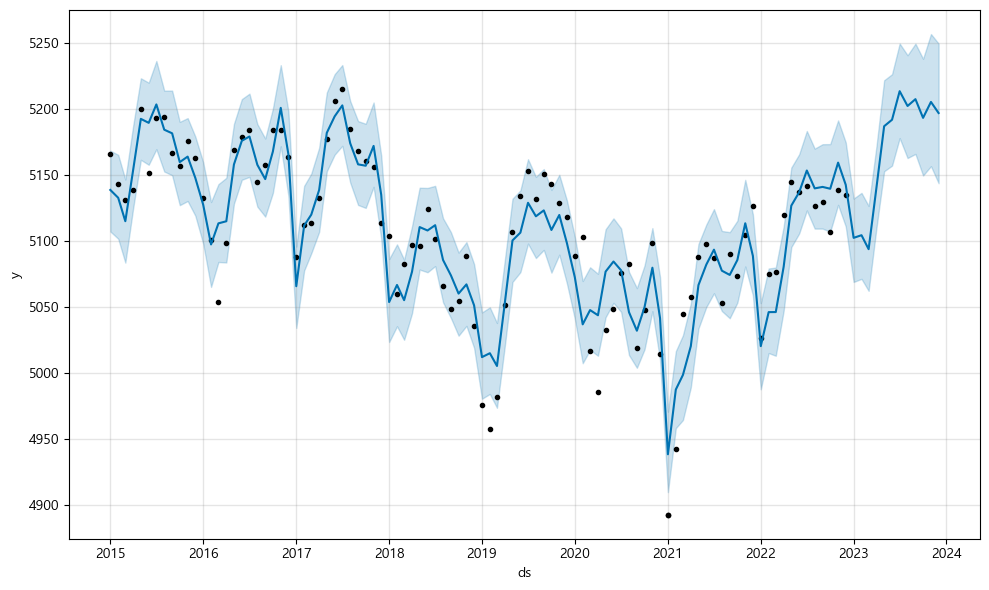

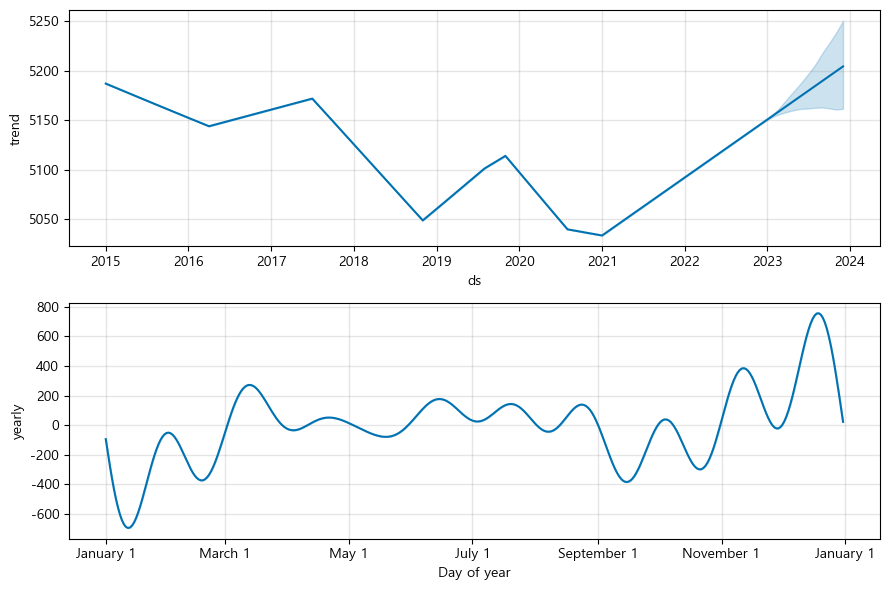

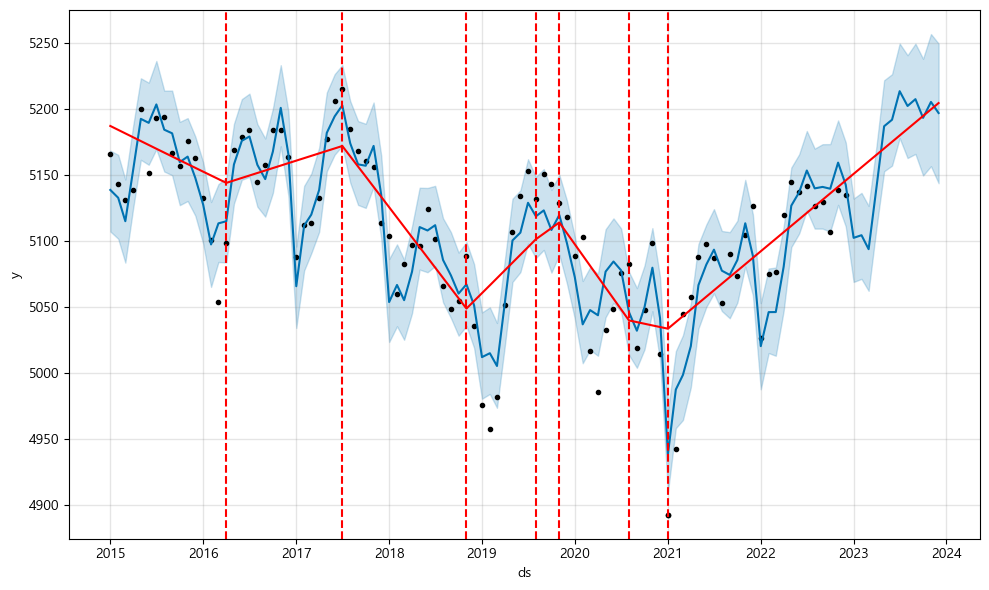

In [173]:
fig1 = prophet_m.plot(forecast)

# Trend 및 Yearly 그래프
fig2 = prophet_m.plot_components(forecast)

# ChangePoint를 포함한 Trend 그래프
# 빨간 점선: ChangePoint
# 빨간 실선: Trend
fig3 = prophet_m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), prophet_m, forecast)

plt.show()  

In [174]:
# 다중 예측
train = city_df_list[9][:int(0.8*len(city_df_list[9]))]
test = city_df_list[9][int(0.8*len(city_df_list[9])):]

train['ds'] = train['날짜']
train['y'] = train['노동력']

train.drop(columns=['날짜', '노동력'], inplace=True)

model = Prophet()

# 추가 변수
regressors = ['총전입 (명)', '총전출 (명)', '순이동 (명)', '시도별성장률', '지역내총생산_명목', '저소득', '중소득', '고소득', '현원', '구인인원', '채용인원', '미충원인원', '부족인원','채용계획인원']

for regressor in regressors:
    model.add_regressor(regressor)

model.fit(train)

14:09:27 - cmdstanpy - INFO - Chain [1] start processing
14:09:28 - cmdstanpy - INFO - Chain [1] done processing


In [176]:
fig_forecast = plot_plotly(model, forecast)
fig_forecast.show()

fig_components = plot_components_plotly(model, forecast)
fig_components.show()

#### 2. ARIMA - Auto ARIMA
- 참고자료
- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima
- https://assaeunji.github.io/statistics/2021-09-08-arimapdq/

ARIMA

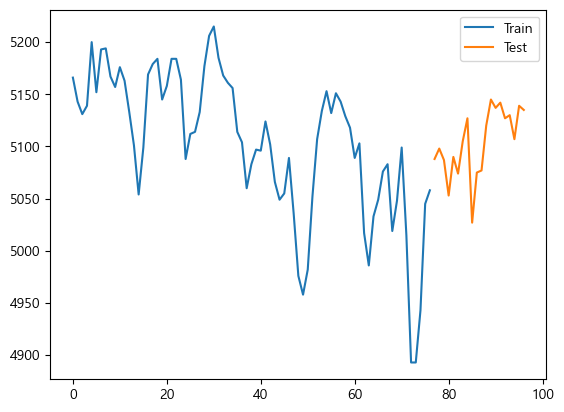

In [47]:
# 단일 예측
train = city_df_list[9]['노동력'][:int(0.8*len(city_df_list[9]))]
test = city_df_list[9]['노동력'][int(0.8*len(city_df_list[9])):]

train.plot(label='Train')
test.plot(label='Test')
plt.legend()
plt.show()

In [48]:
# 최적의 차분 수 도출 
kpss_diffs = pm.arima.ndiffs(train, alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(train, alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)

print(f"Optimized 'd' = {n_diffs}")

Optimized 'd' = 1


In [49]:
'''
model = pm.auto_arima(y=train,
                      d=n_diffs, 
                      start_p= 2,
                      max_p = 5, 
                      start_q= 2,
                      max_q = 5,
                      m=1,
                      seasonal=True,
                      stepwise=True,
                      trace=False)  # step 출력
'''
                      
model = pm.auto_arima(train, d=1, seasonal=False, trace=True)  # default

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=776.610, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=774.976, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=772.819, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=774.711, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=773.934, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=772.201, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=770.452, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=770.900, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=765.236, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=772.037, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=766.363, Time=0.13 se

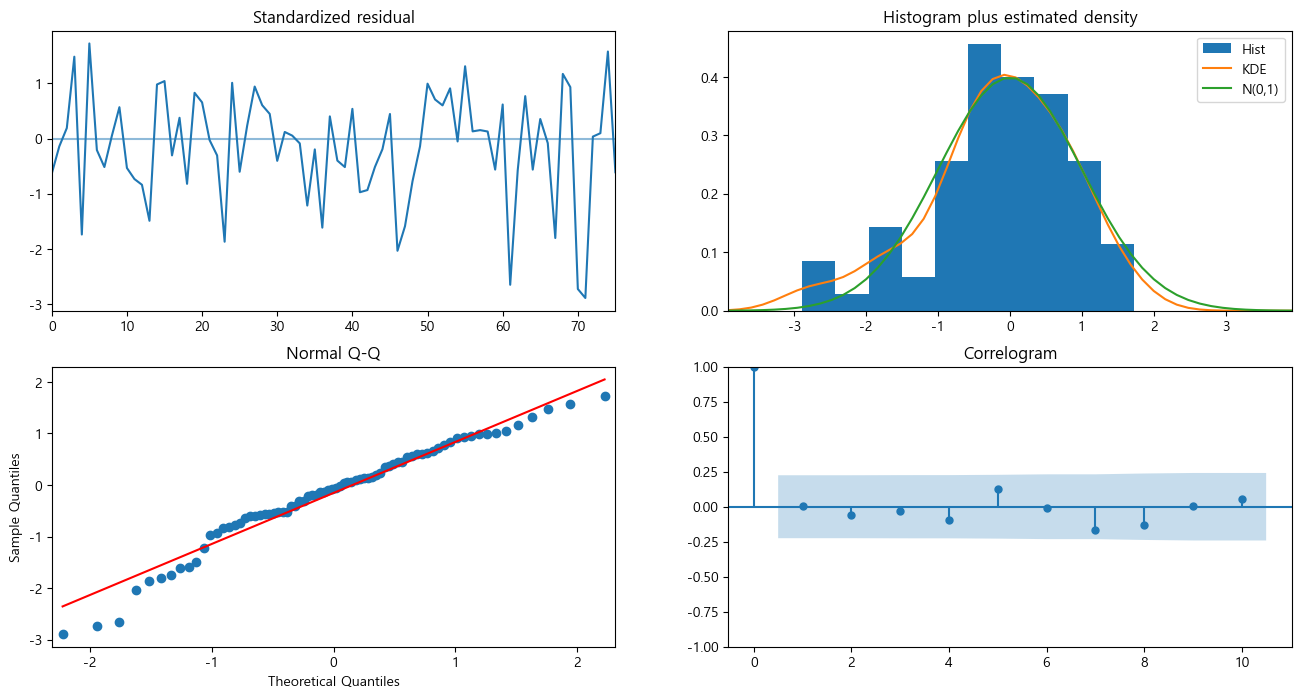

In [50]:
# 정상성 확인
model.plot_diagnostics(figsize=(16,8))
plt.show()

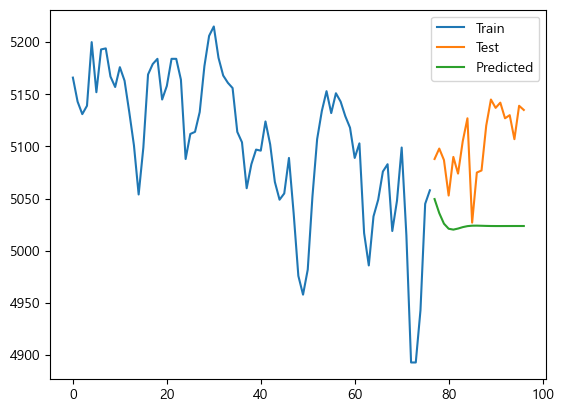

In [51]:
# Prediction - Trend만 고려
pred = model.predict(n_periods=len(test)).to_list()

test_pred = pd.DataFrame({'test':test, 'pred':pred}, index=test.index)

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test_pred.pred, label='Predicted')
plt.legend()
plt.show()

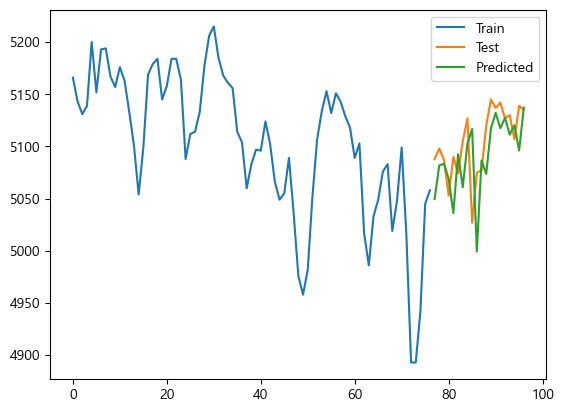

In [52]:
# Prediction - Trend + 변동요인 고려
def forcast_one_step():
    fc, conf = model.predict(n_periods=1, return_conf_int=True)
    return fc.tolist()[0], np.asarray(conf).tolist()[0]

y_pred = []
pred_upper = []
pred_lower = []

# Prediction 및 Model update 반복
for new_ob in test:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model.update(new_ob)

test_pred2 = pd.DataFrame({'test':test, 'pred':y_pred})
y_pred_df = test_pred2['pred']

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_pred_df, label='Predicted')
plt.legend()
plt.show()

In [53]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -478.655
Date:                Sun, 08 Sep 2024   AIC                            965.310
Time:                        15:07:03   BIC                            975.567
Sample:                             0   HQIC                           969.456
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9457      0.134      7.070      0.000       0.684       1.208
ar.L2         -0.2753      0.084     -3.272      0.001      -0.440      -0.110
ma.L1         -0.9051      0.088    -10.293      0.000      -1.077      -0.733
sigma2      1253.2115    171.614      7.303      0.000     916.854    1589.569
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.41
Prob(Q):                              0.97   Prob(JB):                         0.01
Heteroskedasticity (H):               2.01   Skew:                            -0.71
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Ljung-Box (Q) 귀무가설: 잔차가 백색잡음 시계열을 따른다 (기각X)
- Heteroskedasticity (H) 귀무가설: 잔차가 이분산성을 보이지 않는다 (기각 X)
- Jarque-Bera (JB) 귀무가설: 잔차가 정규성을 만족한다 (기각O)

In [54]:
# 예측 오차 MAPE
from sklearn.metrics import mean_absolute_percentage_error
print(f"MAPE : {mean_absolute_percentage_error(test, y_pred):.3f}")

MAPE : 0.006


ARIMAX 

In [60]:
train = city_df_list[9][['노동력', '총전입 (명)', '총전출 (명)', '순이동 (명)', '시도별성장률', '지역내총생산_명목', '저소득', '중소득', '고소득', '현원', '구인인원', '채용인원', '미충원인원', '부족인원', '채용계획인원']][:int(0.8*len(seoul))]
test = city_df_list[9][['노동력', '총전입 (명)', '총전출 (명)', '순이동 (명)', '시도별성장률', '지역내총생산_명목', '저소득', '중소득', '고소득', '현원', '구인인원', '채용인원', '미충원인원', '부족인원', '채용계획인원']][int(0.8*len(seoul)):]
# train.plot(label='Train')
# test.plot(label='Test')
# plt.legend()
# plt.show()

In [61]:
train_labor_force = train['노동력']

# 최적의 차분 수 도출
kpss_diffs = pm.arima.ndiffs(train_labor_force, alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(train_labor_force, alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)

print(f'최적의 차분 수: {n_diffs}')


최적의 차분 수: 1


In [62]:
# ARIMAX 모델에 추가 변수(독립 변수) 포함
exog_variables = train[['총전입 (명)', '총전출 (명)', '순이동 (명)', '시도별성장률', '지역내총생산_명목', '저소득', '중소득', '고소득', '현원', '구인인원', '채용인원', '미충원인원', '부족인원', '채용계획인원']]

# ARIMAX 모델 학습
model = pm.auto_arima(train_labor_force, exogenous=exog_variables, 
                      d=n_diffs, seasonal=False, trace=True, 
                      error_action='ignore', suppress_warnings=True)

model.summary()

test_exog_variables = test[['총전입 (명)', '총전출 (명)', '순이동 (명)', '시도별성장률', '지역내총생산_명목', '저소득', '중소득', '고소득', '현원', '구인인원', '채용인원', '미충원인원', '부족인원', '채용계획인원']]

forecast_steps = 12
predictions = model.predict(n_periods=forecast_steps, exogenous=test_exog_variables)
predictions

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=776.610, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=774.976, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=772.819, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=774.711, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=773.934, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=772.201, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=770.452, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=770.900, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=765.236, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=772.037, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=766.363, Time=0.10 se

77    5049.595187
78    5036.138057
79    5026.010074
80    5021.174560
81    5020.312965
82    5021.343879
83    5022.708071
84    5023.664868
85    5024.085383
86    5024.130600
87    5024.011335
88    5023.874796
dtype: float64

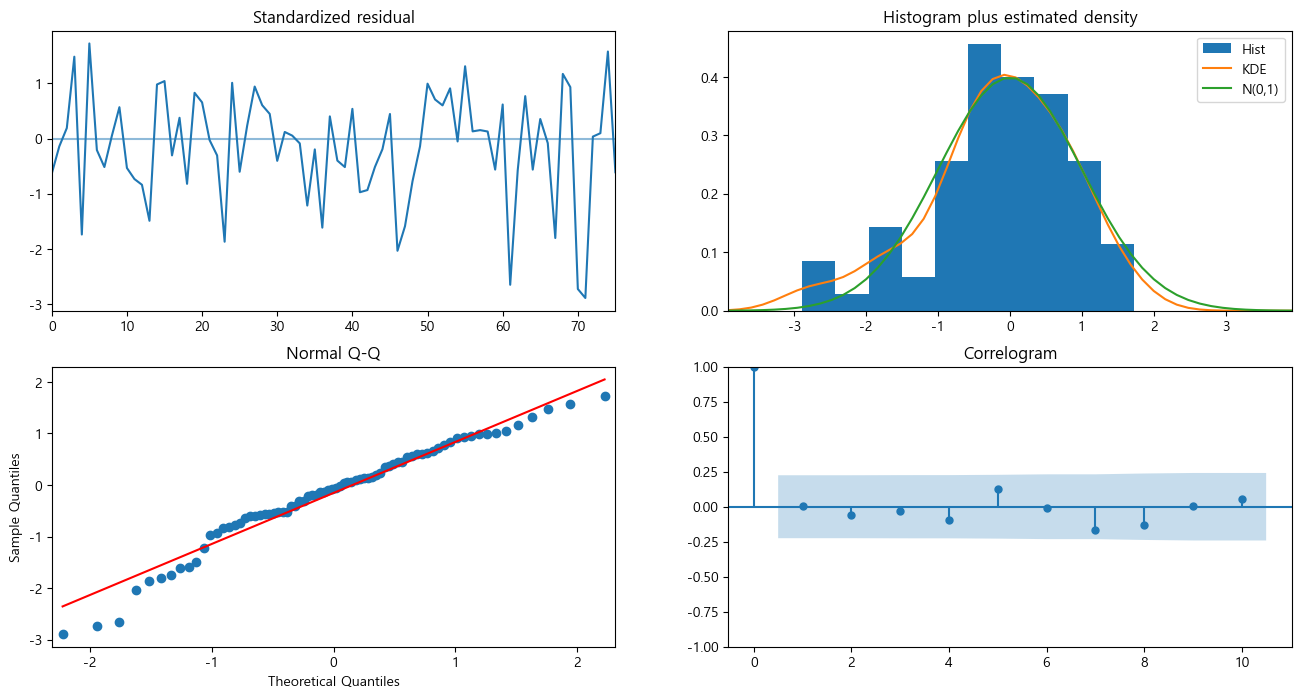

In [63]:
# 정상성 확인
model.plot_diagnostics(figsize=(16,8))
plt.show()

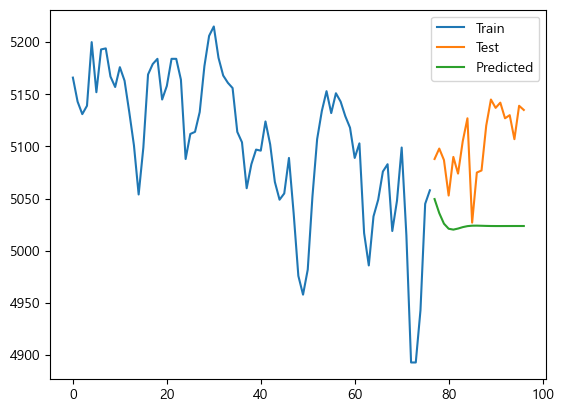

In [64]:
# 트렌드만 고려한 예측 (ARIMAX)
exog_test = test[['총전입 (명)', '총전출 (명)', '순이동 (명)', '시도별성장률', '지역내총생산_명목', '저소득', '중소득', '고소득', '현원', '구인인원', '채용인원', '미충원인원', '부족인원', '채용계획인원']]

pred = model.predict(n_periods=len(test), exogenous=exog_test).tolist()

test_pred = pd.DataFrame({'test': test['노동력'], 'pred': pred}, index=test.index)

# 예측 결과 시각화
plt.plot(train['노동력'], label='Train')
plt.plot(test['노동력'], label='Test')
plt.plot(test_pred['pred'], label='Predicted')
plt.legend()
plt.show()

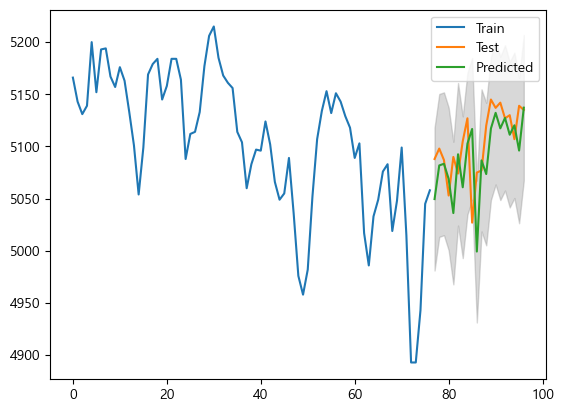

In [65]:
# 트렌드 + 변동 요인 고려한 예측 (ARIMAX)
y_pred = []
pred_upper = []
pred_lower = []

for i in range(len(test)):
    exog_new_ob = exog_test.iloc[i, :].values.reshape(1, -1)  # 외생 변수 추가

    # 모델 예측 및 신뢰 구간 계산
    fc, conf = model.predict(n_periods=1, exogenous=exog_new_ob, return_conf_int=True)
    y_pred.append(fc.tolist()[0])
    pred_upper.append(conf[0][1])
    pred_lower.append(conf[0][0])

    # 모델 업데이트
    new_ob = test['노동력'].iloc[i]
    model.update(new_ob, exogenous=exog_new_ob)

test_pred2 = pd.DataFrame({'test': test['노동력'], 'pred': y_pred}, index=test.index)

plt.plot(train['노동력'], label='Train')
plt.plot(test['노동력'], label='Test')
plt.plot(test_pred2['pred'], label='Predicted')
plt.fill_between(test.index, pred_lower, pred_upper, color='gray', alpha=0.3) 
plt.legend()
plt.show()

In [66]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -478.655
Date:                Sun, 08 Sep 2024   AIC                            965.310
Time:                        15:07:23   BIC                            975.567
Sample:                             0   HQIC                           969.456
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9457      0.134      7.070      0.000       0.684       1.208
ar.L2         -0.2753      0.084     -3.272      0.001      -0.440      -0.110
ma.L1         -0.9051      0.088    -10.293      0.000      -1.077      -0.733
sigma2      1253.2115    171.614      7.303      0.000     916.854    1589.569
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.41
Prob(Q):                              0.97   Prob(JB):                         0.01
Heteroskedasticity (H):               2.01   Skew:                            -0.71
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
# 예측 오차 MAPE 계산
mape = mean_absolute_percentage_error(test['노동력'].values, y_pred)
print(f"MAPE : {mape:.3f}")

MAPE : 0.006


#### 3. LSTM

In [204]:
train = city_df_list[9][:int(0.8*len(city_df_list[9]))]
test = city_df_list[9][int(0.8*len(city_df_list[9])):]

In [ ]:
def process(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['노동력'] = scaler.fit_transform(df[['노동력']])
    
    # 시퀀스 생성
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    SEQ_LENGTH = 12  # 시퀀스 길이
    scaled_data = df['노동력'].values
    X, y = create_sequences(scaled_data, SEQ_LENGTH)
    
    # numpy -> tensor
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    y = torch.tensor(y, dtype=torch.float32)
    
    batch_size = 16
    train_dataset = TensorDataset(X, y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return scaler, scaled_data, train_loader

# LSTM Model 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

scaler, scaled_data, train_loader = process(train)

# Training
input_size = 1
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for sequences, targets in train_loader:
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Prediction
def predict_next_month(model, scaler, scaled_data, seq_length):
    model.eval()
    with torch.no_grad():
        last_seq = scaled_data[-seq_length:].reshape(1, seq_length, 1)
        last_seq = torch.tensor(last_seq, dtype=torch.float32)
        predicted_scaled = model(last_seq)
        predicted = scaler.inverse_transform(predicted_scaled.numpy())
        return predicted[0][0]

SEQ_LENGTH = 12
predicted_value = predict_next_month(model, scaler, scaled_data, SEQ_LENGTH)
print(f'예측된 노동력(2024-01): {predicted_value:.2f}')

In [206]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def prepare_test_data(df, seq_length, scaler):
    # Scale the data
    scaled_data = scaler.transform(df[['노동력']])
    
    # Create sequences
    X, y = create_sequences(scaled_data, seq_length)
    
    # Convert to tensor
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    y = torch.tensor(y, dtype=torch.float32)
    
    return X, y, scaled_data

# Prepare test data
X_test, y_test, scaled_test_data = prepare_test_data(test, SEQ_LENGTH, scaler)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for sequences, targets in train_loader:
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def predict_future_values(model, scaler, test_data, seq_length):
    model.eval()
    with torch.no_grad():
        predictions = []
        for i in range(len(test_data) - seq_length):
            seq = test_data[i:i+seq_length].reshape(1, seq_length, 1)
            seq = torch.tensor(seq, dtype=torch.float32)
            predicted_scaled = model(seq)
            predicted = scaler.inverse_transform(predicted_scaled.numpy())
            predictions.append(predicted[0][0])
        return predictions

# Predict future values
predicted_values = predict_future_values(model, scaler, scaled_test_data, SEQ_LENGTH)

for i, value in enumerate(predicted_values, start=1):
    print(f'예측된 노동력({test.iloc[i+SEQ_LENGTH-1]["날짜"].strftime("%Y-%m")}): {value:.2f}')

Epoch [10/100], Loss: 0.0133
Epoch [20/100], Loss: 0.3207
Epoch [30/100], Loss: 0.2520
Epoch [40/100], Loss: 0.0545
Epoch [50/100], Loss: 0.0437
Epoch [60/100], Loss: 0.0010
Epoch [70/100], Loss: 0.0449
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0067
Epoch [100/100], Loss: 0.0010
예측된 노동력(2022-05): 5107.99
예측된 노동력(2022-06): 5112.07
예측된 노동력(2022-07): 5113.76
예측된 노동력(2022-08): 5115.34
예측된 노동력(2022-09): 5115.05
예측된 노동력(2022-10): 5115.25
예측된 노동력(2022-11): 5113.43
예측된 노동력(2022-12): 5115.17


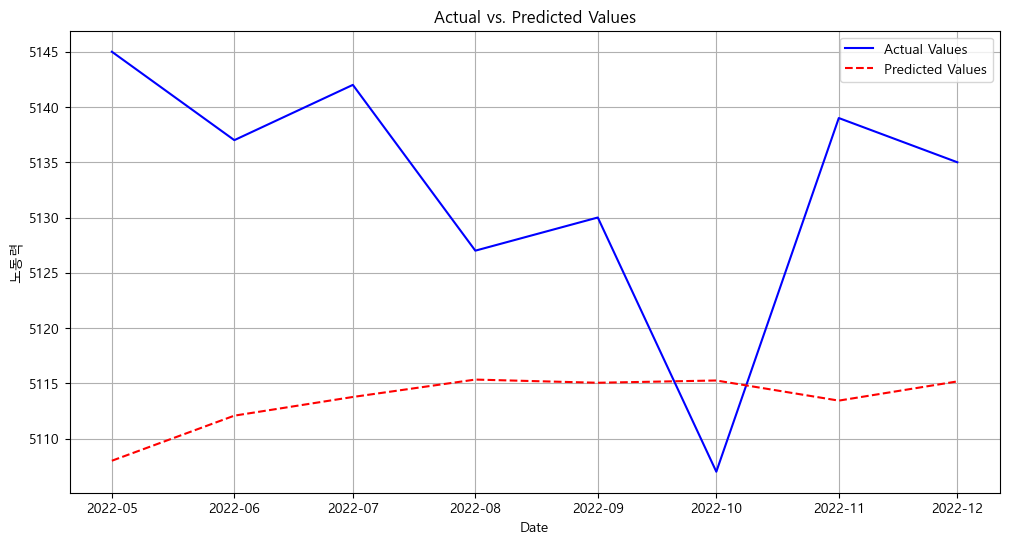

In [ ]:
def get_actual_values(df, seq_length):
    actual_values = df[['노동력']].values
    return actual_values

actual_values = get_actual_values(test, SEQ_LENGTH)

predicted_values = predict_future_values(model, scaler, scaled_test_data, SEQ_LENGTH)

dates = test['날짜'].iloc[SEQ_LENGTH:].values

# 실제값 vs 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_values[SEQ_LENGTH:], label='Actual Values', color='blue')
plt.plot(dates, predicted_values, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('노동력')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

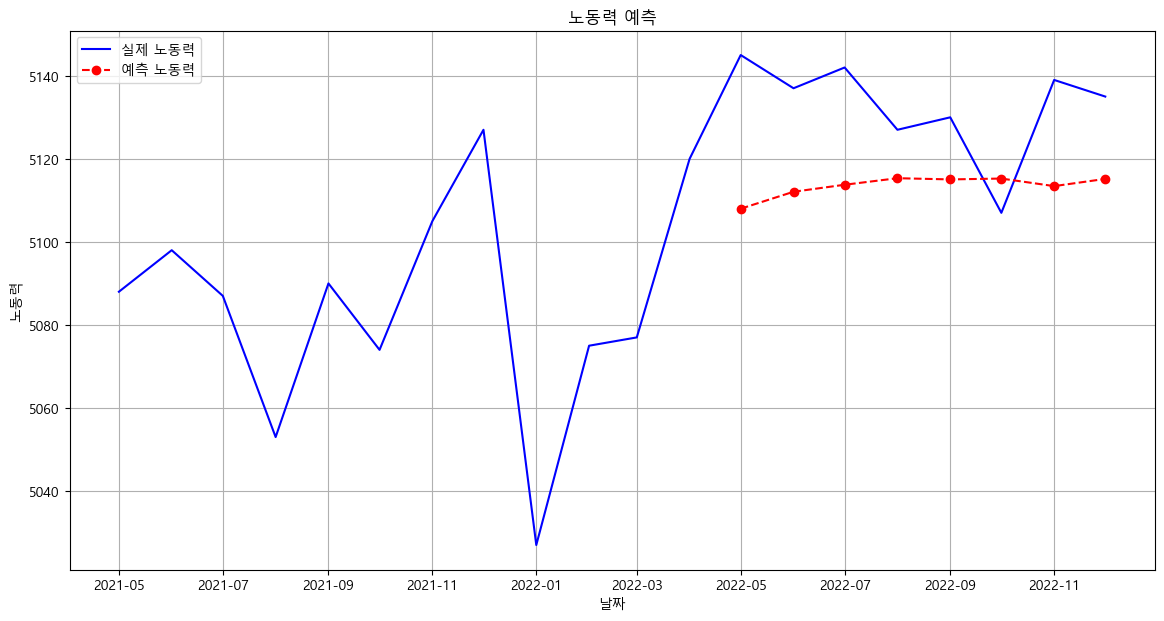

In [ ]:
def plot_predictions(test_df, predictions, scaler, seq_length):
    test_df = test_df.reset_index(drop=True)
    test_df['노동력'] = scaler.transform(test_df[['노동력']])
    
    start_date = test_df.iloc[SEQ_LENGTH]['날짜']  # 예측 결과의 시작과 끝 날짜 계산
    end_date = test_df.iloc[-1]['날짜']
    future_dates = pd.date_range(start=start_date, periods=len(predictions), freq='MS')
    
    plt.figure(figsize=(14, 7))
    plt.plot(test_df['날짜'], scaler.inverse_transform(test_df[['노동력']]), label='실제 노동력', color='blue')  # 실제 값
    plt.plot(future_dates, predictions, color='red', linestyle='--', marker='o', label='예측 노동력')  # 예측 값

    plt.xlabel('날짜')
    plt.ylabel('노동력')
    plt.title('노동력 예측')
    plt.legend()
    plt.grid(True)
    plt.show()

# 예측 결과 시각화
plot_predictions(test, predicted_values, scaler, SEQ_LENGTH)

### 4. RandomForestRegressor

In [11]:
city_list = ['강원', '경남', '제주', '경기', '전남', '인천', '울산', '충남', '세종', '서울', '부산', '대전', '대구', '광주', '충북', '전국', '경북', '전북']
city_df_list = []
for i in range(len(city_list)):
    city_df = final_df[final_df['시도별']==city_list[i]]
    city_df.reset_index(drop=True, inplace=True)
    city_df_list.append(city_df)

In [ ]:
# 시차(lag) 특성 생성
def create_lag_features(df, target_col, lags):
    for lag in range(1, lags+1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# RandomForest 학습 및 예측
def train_and_evaluate(city_name, df):
    df = df.copy()
    df.drop(columns='시도별', inplace=True)
    
    df = create_lag_features(df, '노동력', 3)
    df = df.dropna()
    
    X = df.drop(columns=['노동력', '날짜'])
    y = df['노동력']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # 데이터 분할
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f'[{city_name}] RMSE: {rmse}, MAE: {mae}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='o')
    plt.xlabel('Index')
    plt.ylabel('노동력')
    plt.title(f'Actual vs Predicted 노동력 (RandomForest) - {city_name}')
    plt.legend()
    plt.show()

for i, city_name in enumerate(city_list):
    print(f'\n=== {city_name} ===')
    train_and_evaluate(city_name, city_df_list[i])


=== 강원 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -18.8     | 9.367     | 19.11     | 233.0     |
| 2         | -10.95    | 13.18     | 4.808     | 89.0      |
| 3         | -19.11    | 3.987     | 17.59     | 200.3     |
| 4         | -9.82     | 15.04     | 2.371     | 292.5     |
| 5         | -11.92    | 17.15     | 5.822     | 95.46     |
| 6         | -19.93    | 3.0       | 20.0      | 50.0      |
| 7         | -9.819    | 14.43     | 2.698     | 293.4     |
| 8         | -19.81    | 3.0       | 20.0      | 282.7     |
| 9         | -19.83    | 3.0       | 20.0      | 98.23     |
| 10        | -9.917    | 20.0      | 2.0       | 75.58     |
| 11        | -9.874    | 20.0      | 2.0       | 146.2     |
| 12        | -19.22    | 20.0      | 20.0      | 155.9     |
| 13        | -9.774    | 20.0      | 2.0       | 129.9     |
| 14        | -16.53    | 3.0       | 2.0       | 138.0   

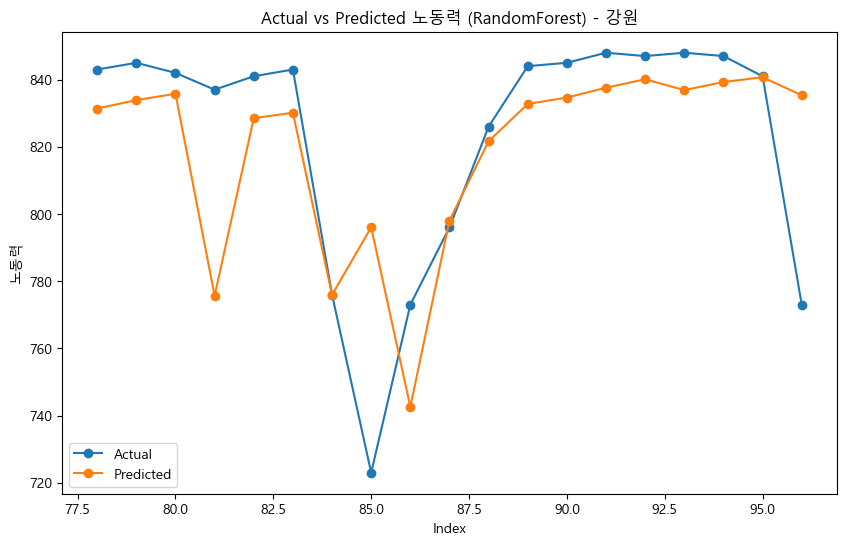


=== 경남 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -14.2     | 9.367     | 19.11     | 233.0     |
| 2         | -7.371    | 13.18     | 4.808     | 89.0      |
| 3         | -14.17    | 3.987     | 17.59     | 200.3     |
| 4         | -6.678    | 15.04     | 2.371     | 292.5     |
| 5         | -7.936    | 17.15     | 5.822     | 95.46     |
| 6         | -14.19    | 20.0      | 20.0      | 50.0      |
| 7         | -6.678    | 16.23     | 2.366     | 292.3     |
| 8         | -14.4     | 20.0      | 20.0      | 300.0     |
| 9         | -6.699    | 13.61     | 2.0       | 274.5     |
| 10        | -14.58    | 3.0       | 20.0      | 120.7     |
| 11        | -14.31    | 3.0       | 18.91     | 271.6     |
| 12        | -14.07    | 19.31     | 19.57     | 85.86     |
| 13        | -12.18    | 3.0       | 2.0       | 96.75     |
| 14        | -6.683    | 20.0      | 2.0       | 281.8   

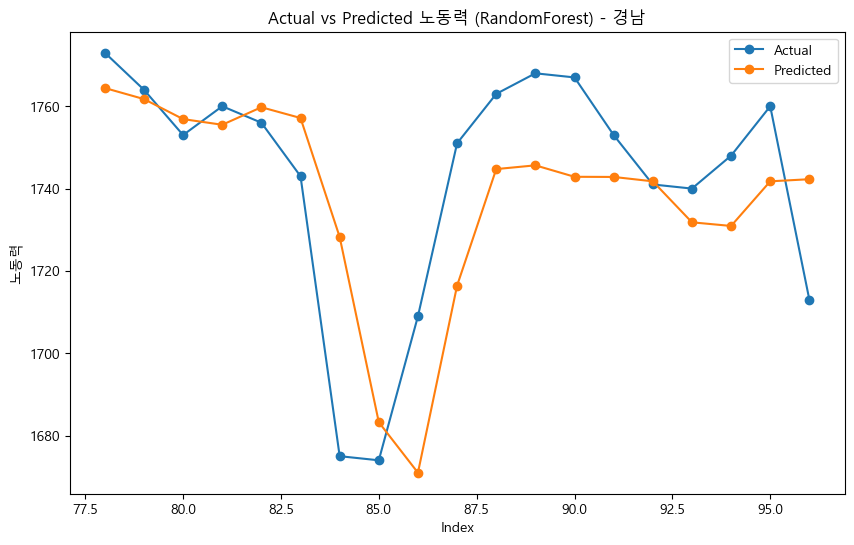


=== 제주 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -5.227    | 9.367     | 19.11     | 233.0     |
| 2         | -2.307    | 13.18     | 4.808     | 89.0      |
| 3         | -5.328    | 3.987     | 17.59     | 200.3     |
| 4         | -1.991    | 15.04     | 2.371     | 292.5     |
| 5         | -2.534    | 17.15     | 5.822     | 95.46     |
| 6         | -5.364    | 20.0      | 20.0      | 50.0      |
| 7         | -2.539    | 13.05     | 5.862     | 88.01     |
| 8         | -4.0      | 3.0       | 2.0       | 101.8     |
| 9         | -4.408    | 20.0      | 13.09     | 300.0     |
| 10        | -2.024    | 9.191     | 2.22      | 284.5     |
| 11        | -4.005    | 3.0       | 2.0       | 295.7     |
| 12        | -1.995    | 19.83     | 2.0       | 282.8     |
| 13        | -4.116    | 12.96     | 12.29     | 275.3     |
| 14        | -5.271    | 20.0      | 20.0      | 145.3   

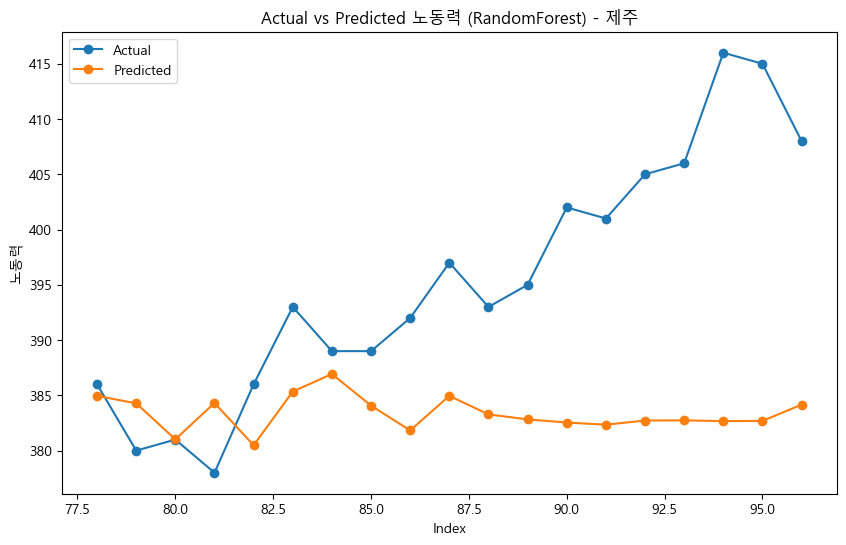


=== 경기 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -99.57    | 9.367     | 19.11     | 233.0     |
| 2         | -33.01    | 13.18     | 4.808     | 89.0      |
| 3         | -94.69    | 3.987     | 17.59     | 200.3     |
| 4         | -28.73    | 15.04     | 2.371     | 292.5     |
| 5         | -34.92    | 17.15     | 5.822     | 95.46     |
| 6         | -103.2    | 20.0      | 20.0      | 50.0      |
| 7         | -29.72    | 15.84     | 3.26      | 292.8     |
| 8         | -53.6     | 3.0       | 2.0       | 131.7     |
| 9         | -101.5    | 3.0       | 20.0      | 300.0     |
| 10        | -28.74    | 19.15     | 2.805     | 273.0     |
| 11        | -102.4    | 3.0       | 20.0      | 102.2     |
| 12        | -53.65    | 3.0       | 2.0       | 273.5     |
| 13        | -29.61    | 20.0      | 2.0       | 154.7     |
| 14        | -101.9    | 20.0      | 20.0      | 148.9   

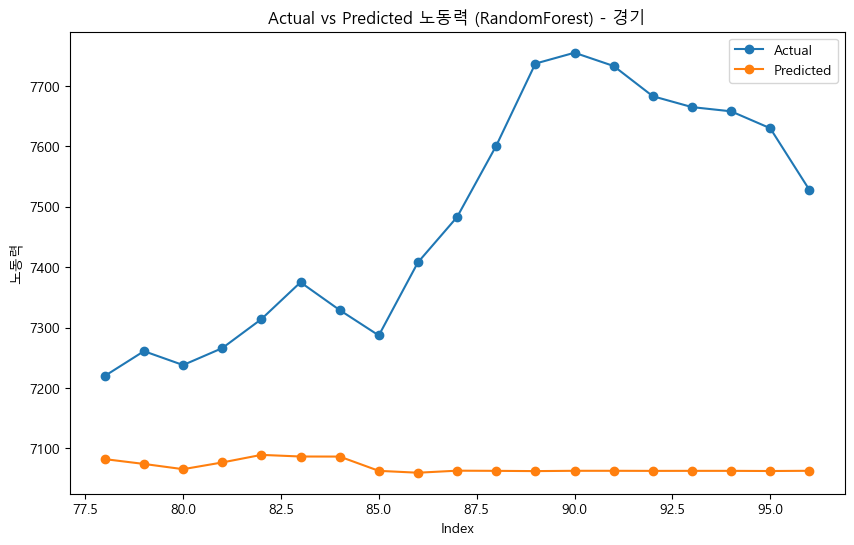


=== 전남 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -12.32    | 9.367     | 19.11     | 233.0     |
| 2         | -5.903    | 13.18     | 4.808     | 89.0      |
| 3         | -11.96    | 3.987     | 17.59     | 200.3     |
| 4         | -5.369    | 15.04     | 2.371     | 292.5     |
| 5         | -6.332    | 17.15     | 5.822     | 95.46     |
| 6         | -12.48    | 20.0      | 20.0      | 50.0      |
| 7         | -5.37     | 15.04     | 2.883     | 291.4     |
| 8         | -12.6     | 3.0       | 20.0      | 300.0     |
| 9         | -12.6     | 3.0       | 20.0      | 99.57     |
| 10        | -5.411    | 19.15     | 2.805     | 273.0     |
| 11        | -8.847    | 3.0       | 2.0       | 272.1     |
| 12        | -12.49    | 20.0      | 20.0      | 272.7     |
| 13        | -5.328    | 20.0      | 2.0       | 77.4      |
| 14        | -8.818    | 3.0       | 2.0       | 70.45   

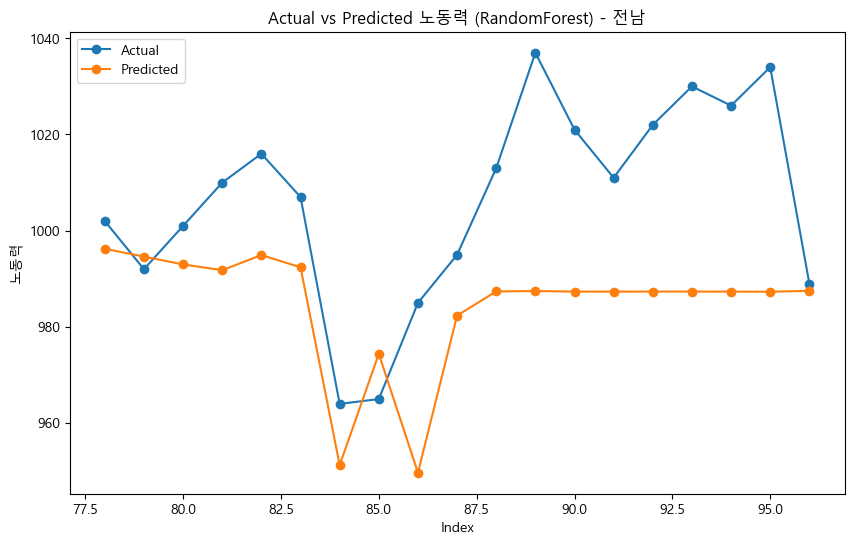


=== 인천 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -12.81    | 9.367     | 19.11     | 233.0     |
| 2         | -7.153    | 13.18     | 4.808     | 89.0      |
| 3         | -13.19    | 3.987     | 17.59     | 200.3     |
| 4         | -6.157    | 15.04     | 2.371     | 292.5     |
| 5         | -7.745    | 17.15     | 5.822     | 95.46     |
| 6         | -13.54    | 3.0       | 20.0      | 50.0      |
| 7         | -6.16     | 15.35     | 2.72      | 293.5     |
| 8         | -13.42    | 3.0       | 20.0      | 295.7     |
| 9         | -13.41    | 3.0       | 20.0      | 98.36     |
| 10        | -6.318    | 20.0      | 2.0       | 75.54     |
| 11        | -6.192    | 20.0      | 2.0       | 270.1     |
| 12        | -6.361    | 20.0      | 2.0       | 146.4     |
| 13        | -13.5     | 3.999     | 20.0      | 150.8     |
| 14        | -6.371    | 20.0      | 2.0       | 127.1   

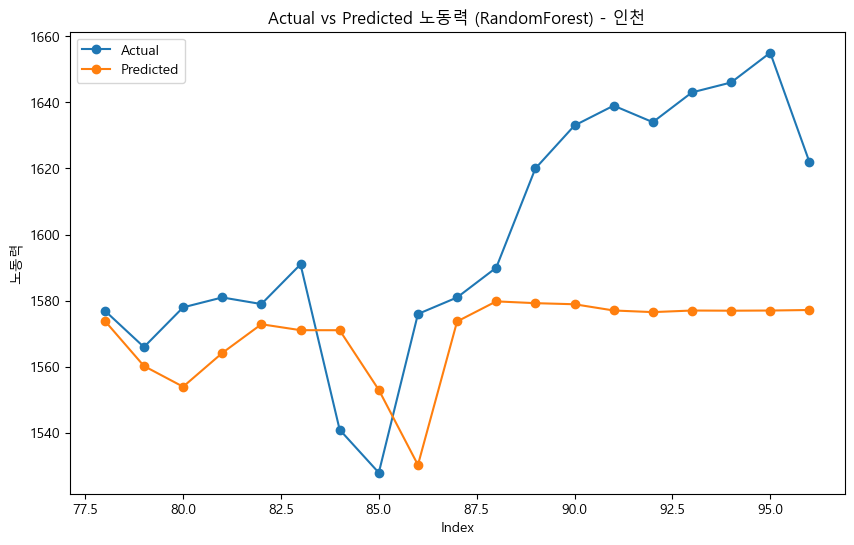


=== 울산 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -4.519    | 9.367     | 19.11     | 233.0     |
| 2         | -2.497    | 13.18     | 4.808     | 89.0      |
| 3         | -4.566    | 3.987     | 17.59     | 200.3     |
| 4         | -2.091    | 15.04     | 2.371     | 292.5     |
| 5         | -2.653    | 17.15     | 5.822     | 95.46     |
| 6         | -4.598    | 20.0      | 20.0      | 50.0      |
| 7         | -2.644    | 13.05     | 5.862     | 88.01     |
| 8         | -4.548    | 3.0       | 16.89     | 300.0     |
| 9         | -2.094    | 20.0      | 2.0       | 281.0     |
| 10        | -3.88     | 3.0       | 2.0       | 103.3     |
| 11        | -2.364    | 6.672     | 2.0       | 279.7     |
| 12        | -4.419    | 20.0      | 17.39     | 276.2     |
| 13        | -3.877    | 3.0       | 2.0       | 263.2     |
| 14        | -2.092    | 13.05     | 2.0       | 285.3   

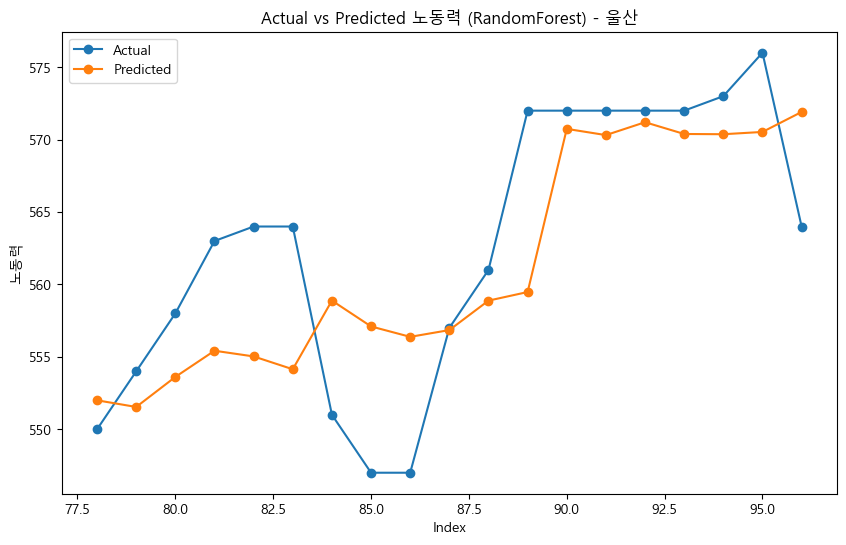


=== 충남 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -21.51    | 9.367     | 19.11     | 233.0     |
| 2         | -12.3     | 13.18     | 4.808     | 89.0      |
| 3         | -22.21    | 3.987     | 17.59     | 200.3     |
| 4         | -10.4     | 15.04     | 2.371     | 292.5     |
| 5         | -13.02    | 17.15     | 5.822     | 95.46     |
| 6         | -22.59    | 20.0      | 20.0      | 50.0      |
| 7         | -11.11    | 15.77     | 3.189     | 292.8     |
| 8         | -18.15    | 3.0       | 2.0       | 281.3     |
| 9         | -11.14    | 6.261     | 2.578     | 298.2     |
| 10        | -22.42    | 3.0       | 17.85     | 93.85     |
| 11        | -11.26    | 20.0      | 2.0       | 78.43     |
| 12        | -15.47    | 4.769     | 2.014     | 69.78     |
| 13        | -20.17    | 19.84     | 15.59     | 77.68     |
| 14        | -22.12    | 3.0       | 18.64     | 300.0   

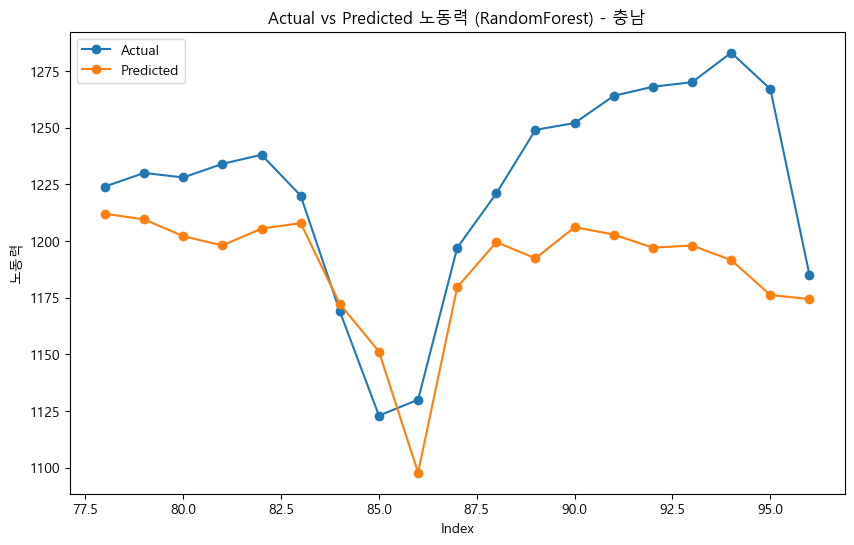


=== 세종 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -5.089    | 9.367     | 19.11     | 233.0     |
| 2         | -1.218    | 13.18     | 4.808     | 89.0      |
| 3         | -4.342    | 3.987     | 17.59     | 200.3     |
| 4         | -0.9853   | 15.04     | 2.371     | 292.5     |
| 5         | -1.265    | 17.15     | 5.822     | 95.46     |
| 6         | -5.894    | 20.0      | 20.0      | 50.0      |
| 7         | -1.29     | 13.05     | 5.862     | 88.01     |
| 8         | -3.717    | 3.0       | 2.0       | 133.3     |
| 9         | -5.136    | 5.215     | 19.84     | 299.0     |
| 10        | -1.004    | 19.61     | 2.113     | 277.7     |
| 11        | -6.106    | 3.0       | 20.0      | 102.5     |
| 12        | -3.569    | 3.0       | 2.0       | 277.2     |
| 13        | -2.43     | 20.0      | 13.77     | 283.2     |
| 14        | -1.295    | 20.0      | 2.0       | 78.73   

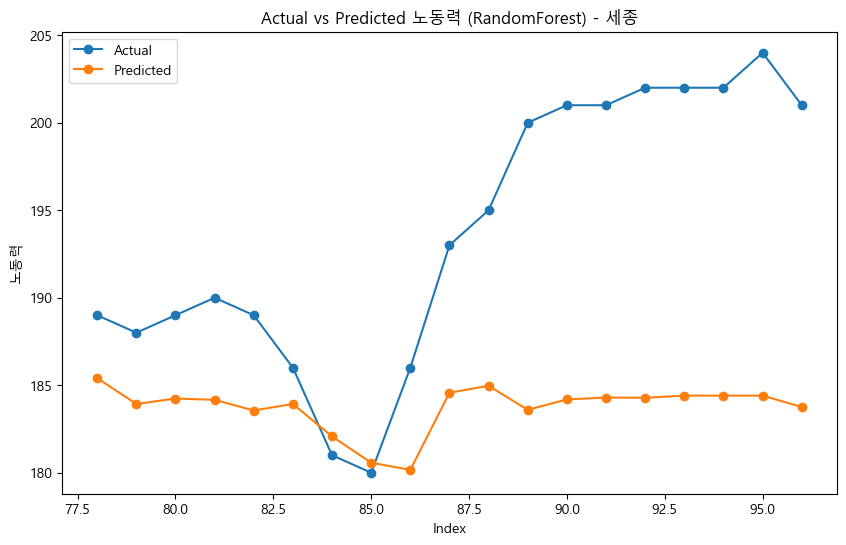


=== 서울 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -29.98    | 9.367     | 19.11     | 233.0     |
| 2         | -17.21    | 13.18     | 4.808     | 89.0      |
| 3         | -30.61    | 3.987     | 17.59     | 200.3     |
| 4         | -14.99    | 15.04     | 2.371     | 292.5     |
| 5         | -18.63    | 17.15     | 5.822     | 95.46     |
| 6         | -31.01    | 3.0       | 20.0      | 50.0      |
| 7         | -15.6     | 15.78     | 3.189     | 292.8     |
| 8         | -25.95    | 3.0       | 2.0       | 275.4     |
| 9         | -22.24    | 4.178     | 5.511     | 299.8     |
| 10        | -30.66    | 3.0       | 17.59     | 93.4      |
| 11        | -14.99    | 20.0      | 2.0       | 282.9     |
| 12        | -15.67    | 19.64     | 2.361     | 74.15     |
| 13        | -15.36    | 20.0      | 2.0       | 139.7     |
| 14        | -30.02    | 20.0      | 19.02     | 146.1   

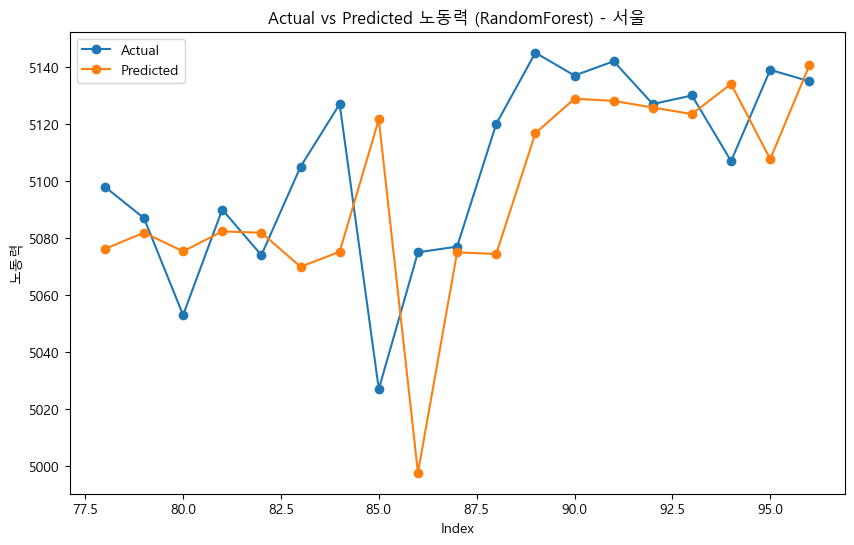


=== 부산 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -11.8     | 9.367     | 19.11     | 233.0     |
| 2         | -6.58     | 13.18     | 4.808     | 89.0      |
| 3         | -11.5     | 3.987     | 17.59     | 200.3     |
| 4         | -5.648    | 15.04     | 2.371     | 292.5     |
| 5         | -7.193    | 17.15     | 5.822     | 95.46     |
| 6         | -12.28    | 3.0       | 20.0      | 50.0      |
| 7         | -5.95     | 15.77     | 3.187     | 292.8     |
| 8         | -9.929    | 3.0       | 2.0       | 278.3     |
| 9         | -6.916    | 5.091     | 2.0       | 300.0     |
| 10        | -11.79    | 3.0       | 18.76     | 92.95     |
| 11        | -5.95     | 19.98     | 3.033     | 77.37     |
| 12        | -6.303    | 6.638     | 2.502     | 74.2      |
| 13        | -5.752    | 20.0      | 2.0       | 132.9     |
| 14        | -5.747    | 20.0      | 2.0       | 149.6   

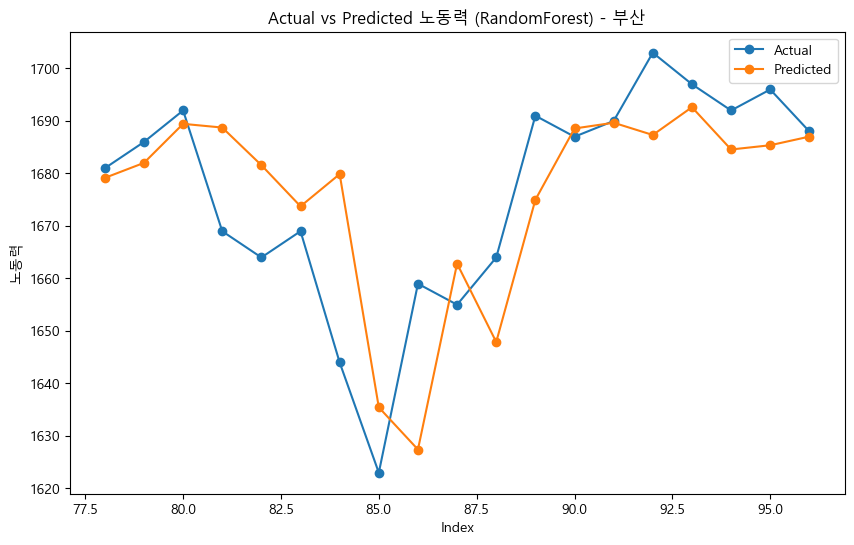


=== 대전 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -5.872    | 9.367     | 19.11     | 233.0     |
| 2         | -2.989    | 13.18     | 4.808     | 89.0      |
| 3         | -5.8      | 3.987     | 17.59     | 200.3     |
| 4         | -2.75     | 15.04     | 2.371     | 292.5     |
| 5         | -3.299    | 17.15     | 5.822     | 95.46     |
| 6         | -6.258    | 3.0       | 20.0      | 50.0      |
| 7         | -3.279    | 13.05     | 5.862     | 88.01     |
| 8         | -5.053    | 3.0       | 2.0       | 97.42     |
| 9         | -3.571    | 20.0      | 6.769     | 300.0     |
| 10        | -4.396    | 11.35     | 10.93     | 287.8     |
| 11        | -2.808    | 8.972     | 2.0       | 299.4     |
| 12        | -2.714    | 19.23     | 2.041     | 84.93     |
| 13        | -6.085    | 20.0      | 20.0      | 146.0     |
| 14        | -2.819    | 20.0      | 2.0       | 68.96   

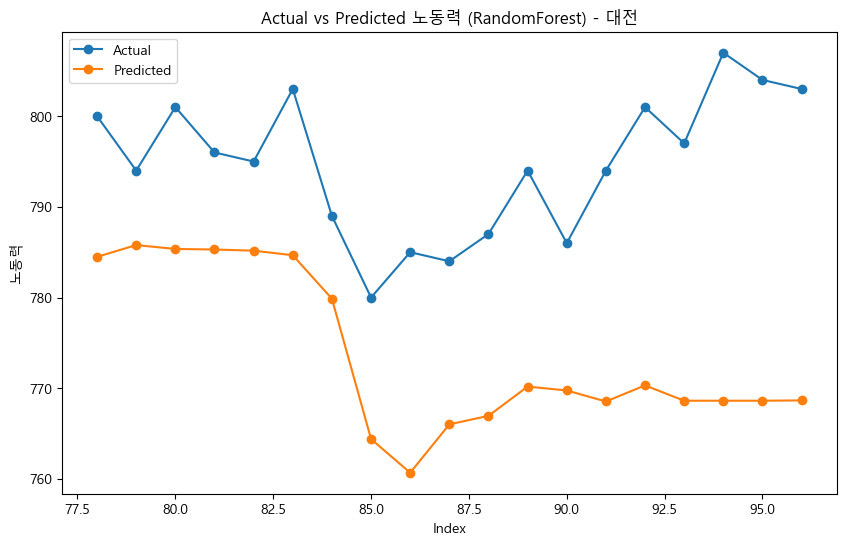


=== 대구 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -13.49    | 9.367     | 19.11     | 233.0     |
| 2         | -6.65     | 13.18     | 4.808     | 89.0      |
| 3         | -13.0     | 3.987     | 17.59     | 200.3     |
| 4         | -6.018    | 15.04     | 2.371     | 292.5     |
| 5         | -7.305    | 17.15     | 5.822     | 95.46     |
| 6         | -13.79    | 3.0       | 20.0      | 50.0      |
| 7         | -6.022    | 15.41     | 2.783     | 293.5     |
| 8         | -13.94    | 3.0       | 20.0      | 300.0     |
| 9         | -13.85    | 3.0       | 20.0      | 97.61     |
| 10        | -5.748    | 20.0      | 2.0       | 76.34     |
| 11        | -6.002    | 20.0      | 2.0       | 270.1     |
| 12        | -5.974    | 20.0      | 2.0       | 146.3     |
| 13        | -13.88    | 4.825     | 20.0      | 151.3     |
| 14        | -5.866    | 20.0      | 2.0       | 127.1   

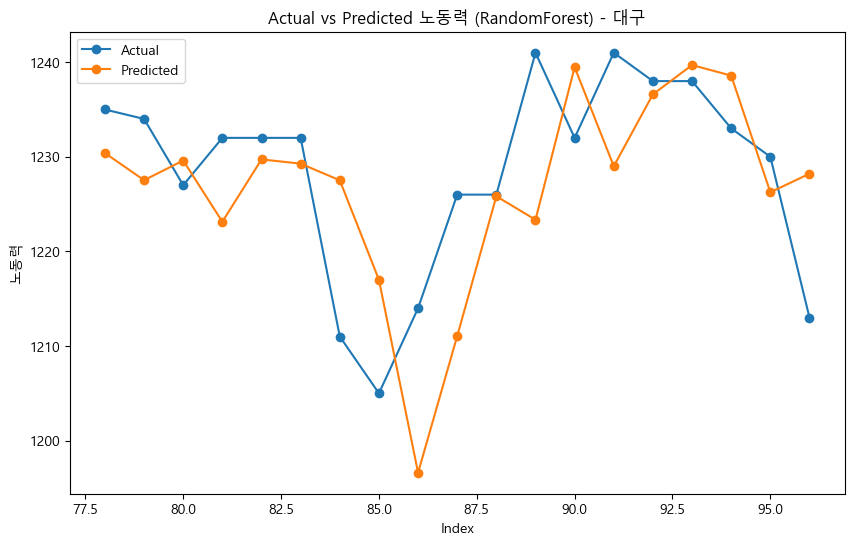


=== 광주 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -5.457    | 9.367     | 19.11     | 233.0     |
| 2         | -3.14     | 13.18     | 4.808     | 89.0      |
| 3         | -5.641    | 3.987     | 17.59     | 200.3     |
| 4         | -2.664    | 15.04     | 2.371     | 292.5     |
| 5         | -3.425    | 17.15     | 5.822     | 95.46     |
| 6         | -5.811    | 3.0       | 20.0      | 50.0      |
| 7         | -3.378    | 13.05     | 5.862     | 88.01     |
| 8         | -4.87     | 12.48     | 13.58     | 300.0     |
| 9         | -2.661    | 18.11     | 2.0       | 283.5     |
| 10        | -5.013    | 3.907     | 2.513     | 283.0     |
| 11        | -4.158    | 20.0      | 8.815     | 287.8     |
| 12        | -3.186    | 6.661     | 2.0       | 95.43     |
| 13        | -2.665    | 20.0      | 2.0       | 273.7     |
| 14        | -2.663    | 20.0      | 2.0       | 262.0   

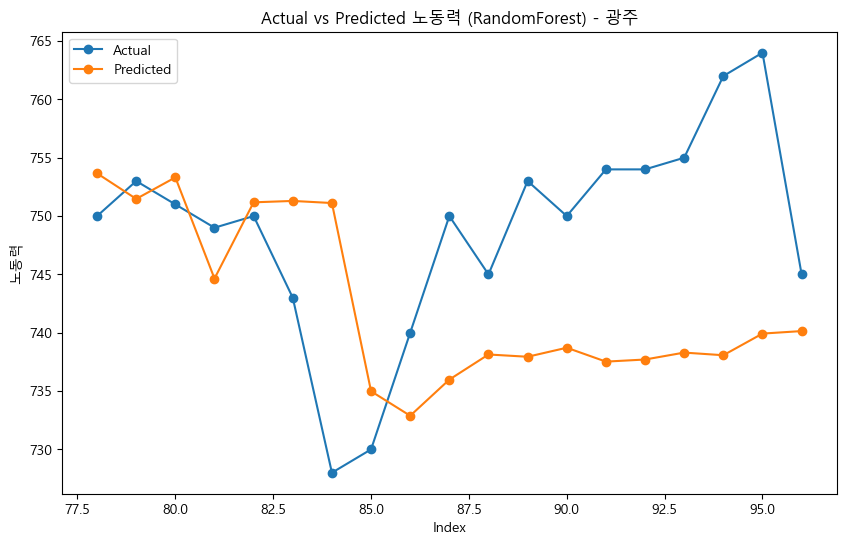


=== 충북 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -13.84    | 9.367     | 19.11     | 233.0     |
| 2         | -7.373    | 13.18     | 4.808     | 89.0      |
| 3         | -13.95    | 3.987     | 17.59     | 200.3     |
| 4         | -6.543    | 15.04     | 2.371     | 292.5     |
| 5         | -8.005    | 17.15     | 5.822     | 95.46     |
| 6         | -14.4     | 20.0      | 20.0      | 50.0      |
| 7         | -6.543    | 16.14     | 2.35      | 292.1     |
| 8         | -14.09    | 20.0      | 20.0      | 300.0     |
| 9         | -6.657    | 8.628     | 2.0       | 275.7     |
| 10        | -14.48    | 3.0       | 20.0      | 123.2     |
| 11        | -6.619    | 20.0      | 2.0       | 262.2     |
| 12        | -6.694    | 20.0      | 2.0       | 162.4     |
| 13        | -14.15    | 20.0      | 20.0      | 163.5     |
| 14        | -13.34    | 20.0      | 17.32     | 269.6   

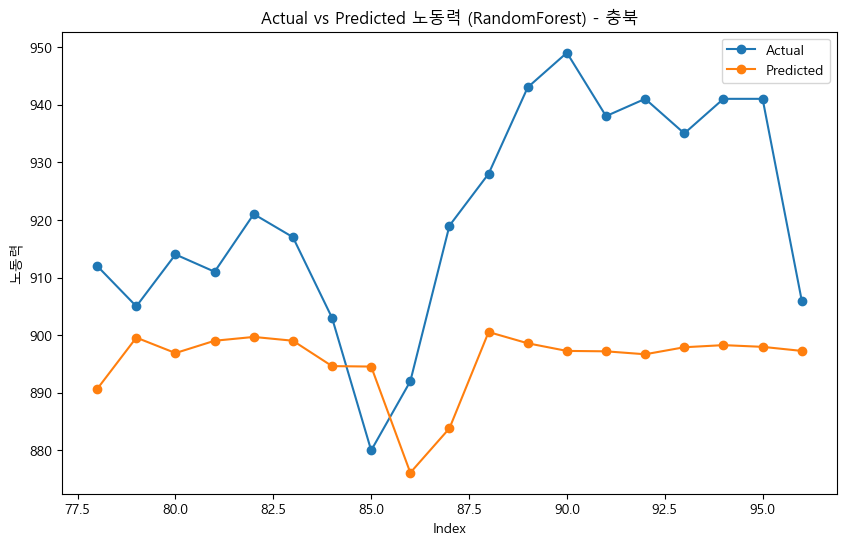


=== 전국 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -261.6    | 9.367     | 19.11     | 233.0     |
| 2         | -123.6    | 13.18     | 4.808     | 89.0      |
| 3         | -244.2    | 3.987     | 17.59     | 200.3     |
| 4         | -104.0    | 15.04     | 2.371     | 292.5     |
| 5         | -131.0    | 17.15     | 5.822     | 95.46     |
| 6         | -273.3    | 20.0      | 20.0      | 50.0      |
| 7         | -109.2    | 15.8      | 3.215     | 292.8     |
| 8         | -202.8    | 3.0       | 2.0       | 274.1     |
| 9         | -204.1    | 3.717     | 6.768     | 299.9     |
| 10        | -244.9    | 3.0       | 17.22     | 95.59     |
| 11        | -104.4    | 20.0      | 2.0       | 282.8     |
| 12        | -108.1    | 19.64     | 2.361     | 74.15     |
| 13        | -158.3    | 4.323     | 2.218     | 71.49     |
| 14        | -105.7    | 20.0      | 2.0       | 132.8   

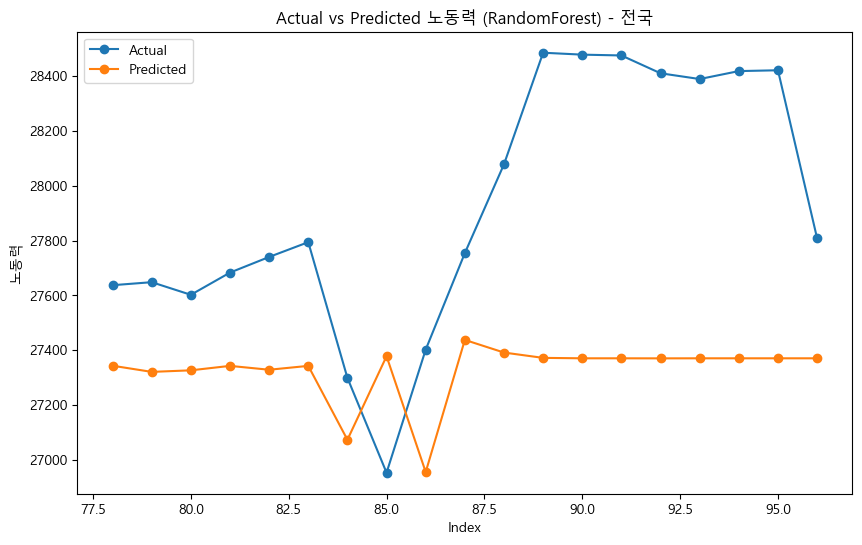


=== 경북 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -17.22    | 9.367     | 19.11     | 233.0     |
| 2         | -9.105    | 13.18     | 4.808     | 89.0      |
| 3         | -17.54    | 3.987     | 17.59     | 200.3     |
| 4         | -8.021    | 15.04     | 2.371     | 292.5     |
| 5         | -9.826    | 17.15     | 5.822     | 95.46     |
| 6         | -17.95    | 20.0      | 20.0      | 50.0      |
| 7         | -8.269    | 15.8      | 3.21      | 292.8     |
| 8         | -14.38    | 3.0       | 2.0       | 272.9     |
| 9         | -14.57    | 3.717     | 6.768     | 299.9     |
| 10        | -17.69    | 3.0       | 17.63     | 93.8      |
| 11        | -8.036    | 20.0      | 2.0       | 283.2     |
| 12        | -8.109    | 20.0      | 2.0       | 77.53     |
| 13        | -8.161    | 20.0      | 2.0       | 136.3     |
| 14        | -16.92    | 20.0      | 18.61     | 146.3   

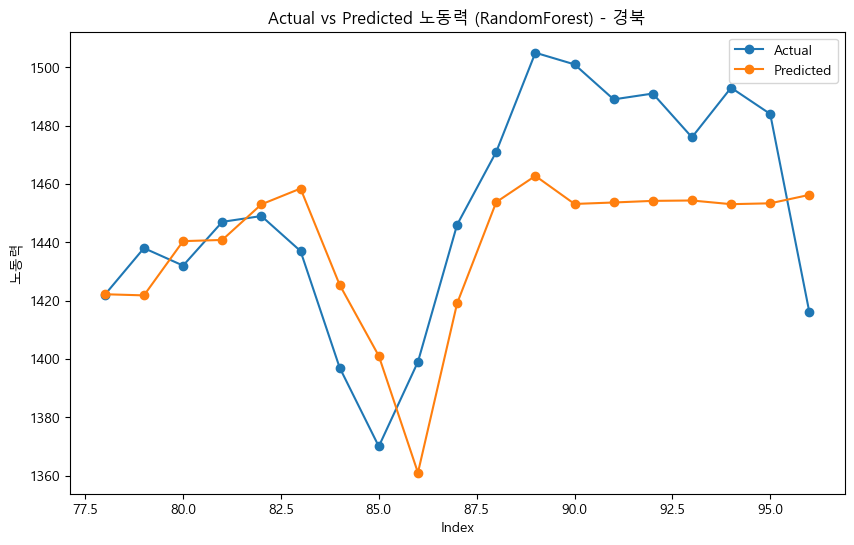


=== 전북 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -12.07    | 9.367     | 19.11     | 233.0     |
| 2         | -5.584    | 13.18     | 4.808     | 89.0      |
| 3         | -11.69    | 3.987     | 17.59     | 200.3     |
| 4         | -5.172    | 15.04     | 2.371     | 292.5     |
| 5         | -6.038    | 17.15     | 5.822     | 95.46     |
| 6         | -12.79    | 20.0      | 20.0      | 50.0      |
| 7         | -5.164    | 15.01     | 2.868     | 291.3     |
| 8         | -12.84    | 3.0       | 20.0      | 300.0     |
| 9         | -12.77    | 3.0       | 20.0      | 98.52     |
| 10        | -5.114    | 20.0      | 2.0       | 77.56     |
| 11        | -5.206    | 20.0      | 2.0       | 269.5     |
| 12        | -5.148    | 20.0      | 2.0       | 145.7     |
| 13        | -12.55    | 20.0      | 20.0      | 158.0     |
| 14        | -5.095    | 20.0      | 2.0       | 127.3   

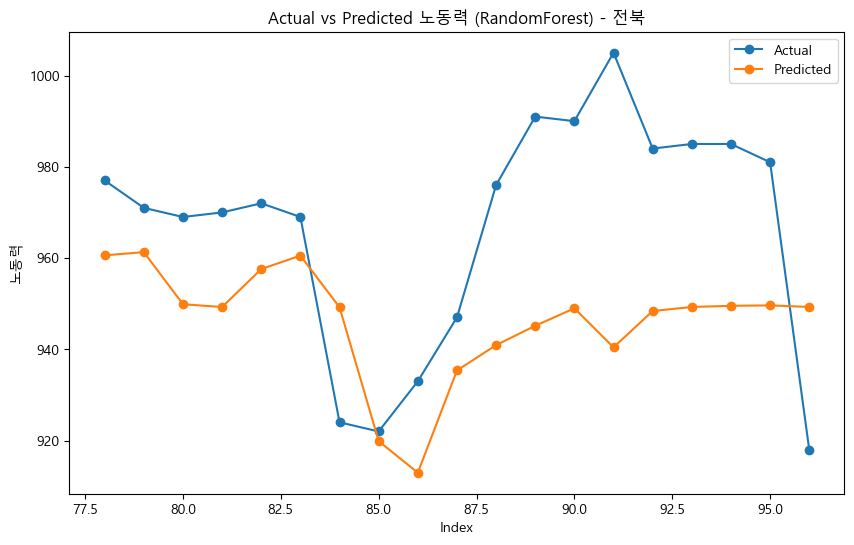

In [ ]:
# 하이퍼파라미터 튜닝 후 RF 결과
def create_lag_features(df, target_col, lags):
    for lag in range(1, lags+1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# 범주형 변수 인코딩
def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df

# RandomForest 교차 검증 함수
def rf_cv(n_estimators, max_depth, min_samples_split, df_train, y_train):
    model = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  random_state=42)
    
    model.fit(df_train, y_train)
    y_pred = model.predict(df_train)
    
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    
    return -rmse  # Bayesian Optimization은 최대화를 하므로, 음수로 변환

# Bayesian Optimization 적용
def bayesian_opt_rf(df):
    df = create_lag_features(df, '노동력', 3)
    
    df = encode_categorical_columns(df)
    
    df = df.dropna()
    
    X = df.drop(columns=['노동력', '날짜'])
    y = df['노동력']
    
    # Hyperparameter 범위 설정
    pbounds = {
        'n_estimators': (50, 300),
        'max_depth': (3, 20),
        'min_samples_split': (2, 20)
    }
    
    optimizer = BayesianOptimization(
        f=lambda n_estimators, max_depth, min_samples_split: rf_cv(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            df_train=X,
            y_train=y
        ),
        pbounds=pbounds,
        random_state=42,
    )
    
    optimizer.maximize(init_points=5, n_iter=25)

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_samples_split'] = int(best_params['min_samples_split'])
    
    print(f"Best Parameters: {best_params}")
    
    return best_params

for i, city_name in enumerate(city_list):
    print(f"\n=== {city_name} ===")
    city_df = city_df_list[i]
    
    best_params = bayesian_opt_rf(city_df)
    
    df = create_lag_features(city_df, '노동력', 3).dropna()
    
    X = df.drop(columns=['노동력', '날짜'])
    y = df['노동력']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='o')
    plt.xlabel('Index')
    plt.ylabel('노동력')
    plt.title(f'Actual vs Predicted 노동력 (RandomForest) - {city_name}')
    plt.legend()
    plt.show()



=== 강원 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -18.8     | 9.367     | 19.11     | 233.0     |
| 2         | -10.95    | 13.18     | 4.808     | 89.0      |
| 3         | -19.11    | 3.987     | 17.59     | 200.3     |
| 4         | -9.82     | 15.04     | 2.371     | 292.5     |
| 5         | -11.92    | 17.15     | 5.822     | 95.46     |
| 6         | -19.93    | 3.0       | 20.0      | 50.0      |
| 7         | -9.819    | 14.43     | 2.698     | 293.4     |
| 8         | -19.81    | 3.0       | 20.0      | 282.7     |
| 9         | -19.83    | 3.0       | 20.0      | 98.23     |
| 10        | -9.917    | 20.0      | 2.0       | 75.58     |
| 11        | -9.874    | 20.0      | 2.0       | 146.2     |
| 12        | -19.22    | 20.0      | 20.0      | 155.9     |
| 13        | -9.774    | 20.0      | 2.0       | 129.9     |
| 14        | -16.53    | 3.0       | 2.0       | 138.0   

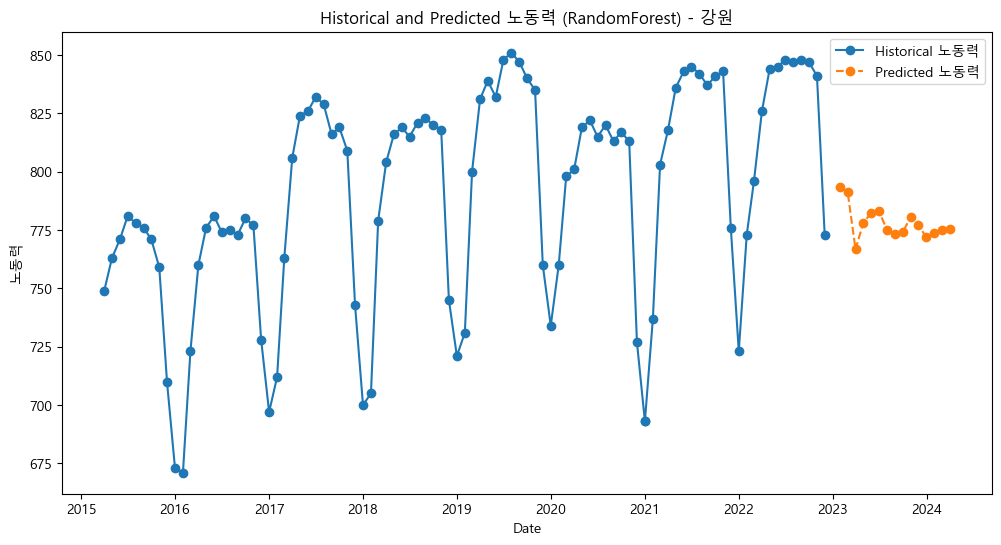


=== 경남 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -14.2     | 9.367     | 19.11     | 233.0     |
| 2         | -7.371    | 13.18     | 4.808     | 89.0      |
| 3         | -14.17    | 3.987     | 17.59     | 200.3     |
| 4         | -6.678    | 15.04     | 2.371     | 292.5     |
| 5         | -7.936    | 17.15     | 5.822     | 95.46     |
| 6         | -14.19    | 20.0      | 20.0      | 50.0      |
| 7         | -6.678    | 16.23     | 2.366     | 292.3     |
| 8         | -14.4     | 20.0      | 20.0      | 300.0     |
| 9         | -6.699    | 13.61     | 2.0       | 274.5     |
| 10        | -14.58    | 3.0       | 20.0      | 120.7     |
| 11        | -14.31    | 3.0       | 18.91     | 271.6     |
| 12        | -14.07    | 19.31     | 19.57     | 85.86     |
| 13        | -12.18    | 3.0       | 2.0       | 96.75     |
| 14        | -6.683    | 20.0      | 2.0       | 281.8   

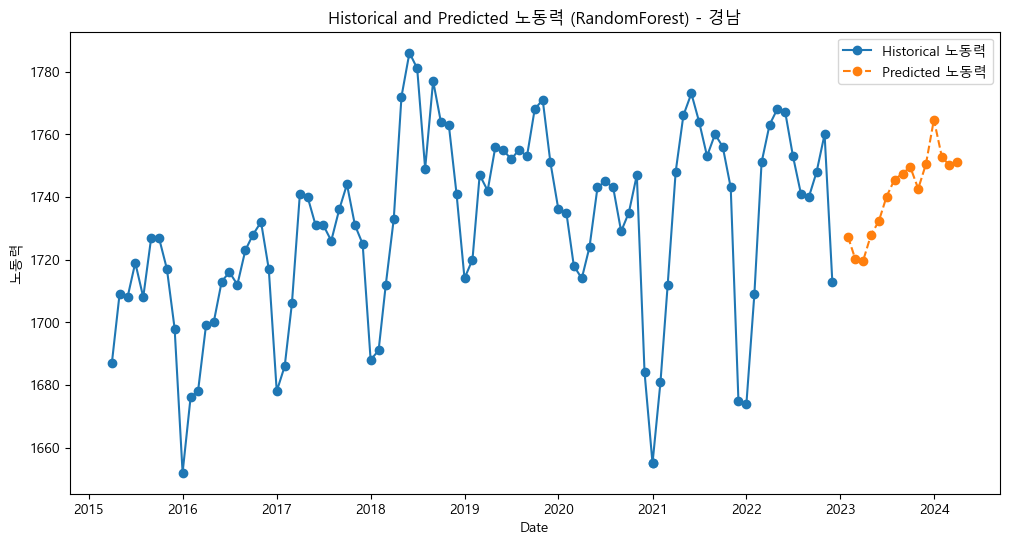


=== 제주 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -5.227    | 9.367     | 19.11     | 233.0     |
| 2         | -2.307    | 13.18     | 4.808     | 89.0      |
| 3         | -5.328    | 3.987     | 17.59     | 200.3     |
| 4         | -1.991    | 15.04     | 2.371     | 292.5     |
| 5         | -2.534    | 17.15     | 5.822     | 95.46     |
| 6         | -5.364    | 20.0      | 20.0      | 50.0      |
| 7         | -2.539    | 13.05     | 5.862     | 88.01     |
| 8         | -4.0      | 3.0       | 2.0       | 101.8     |
| 9         | -4.408    | 20.0      | 13.09     | 300.0     |
| 10        | -2.024    | 9.191     | 2.22      | 284.5     |
| 11        | -4.005    | 3.0       | 2.0       | 295.7     |
| 12        | -1.995    | 19.83     | 2.0       | 282.8     |
| 13        | -4.116    | 12.96     | 12.29     | 275.3     |
| 14        | -5.271    | 20.0      | 20.0      | 145.3   

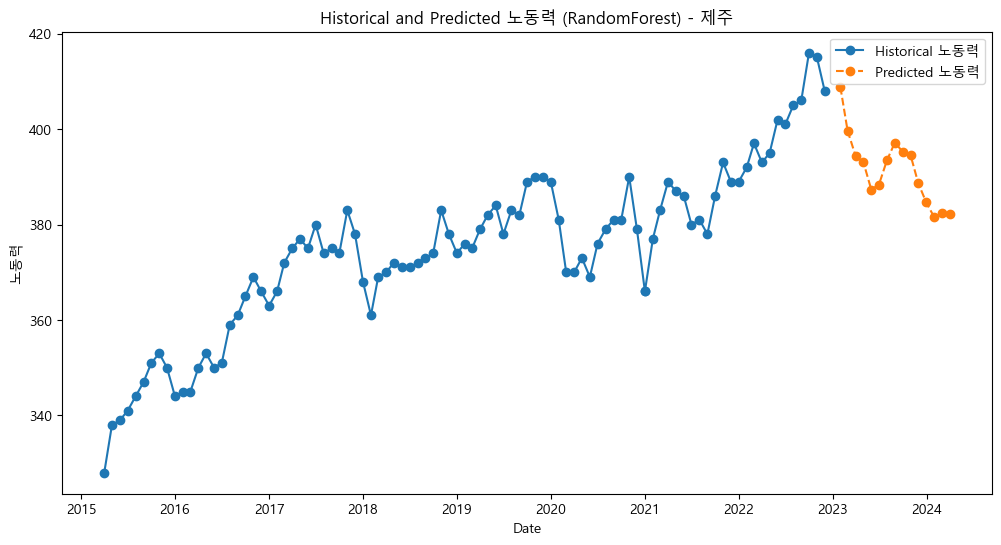


=== 경기 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -99.57    | 9.367     | 19.11     | 233.0     |
| 2         | -33.01    | 13.18     | 4.808     | 89.0      |
| 3         | -94.69    | 3.987     | 17.59     | 200.3     |
| 4         | -28.73    | 15.04     | 2.371     | 292.5     |
| 5         | -34.92    | 17.15     | 5.822     | 95.46     |
| 6         | -103.2    | 20.0      | 20.0      | 50.0      |
| 7         | -29.72    | 15.84     | 3.26      | 292.8     |
| 8         | -53.6     | 3.0       | 2.0       | 131.7     |
| 9         | -101.5    | 3.0       | 20.0      | 300.0     |
| 10        | -28.74    | 19.15     | 2.805     | 273.0     |
| 11        | -102.4    | 3.0       | 20.0      | 102.2     |
| 12        | -53.65    | 3.0       | 2.0       | 273.5     |
| 13        | -29.61    | 20.0      | 2.0       | 154.7     |
| 14        | -101.9    | 20.0      | 20.0      | 148.9   

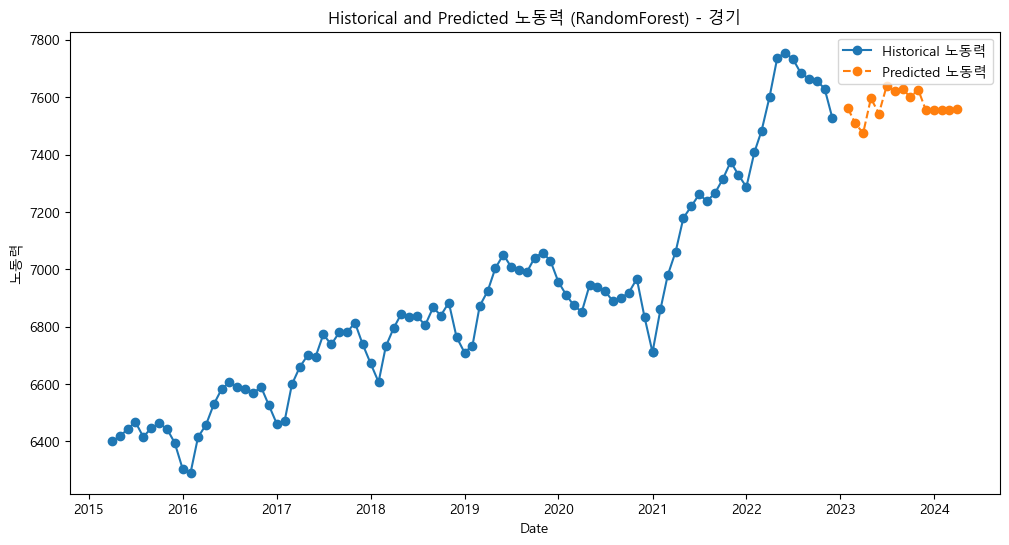


=== 전남 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -12.32    | 9.367     | 19.11     | 233.0     |
| 2         | -5.903    | 13.18     | 4.808     | 89.0      |
| 3         | -11.96    | 3.987     | 17.59     | 200.3     |
| 4         | -5.369    | 15.04     | 2.371     | 292.5     |
| 5         | -6.332    | 17.15     | 5.822     | 95.46     |
| 6         | -12.48    | 20.0      | 20.0      | 50.0      |
| 7         | -5.37     | 15.04     | 2.883     | 291.4     |
| 8         | -12.6     | 3.0       | 20.0      | 300.0     |
| 9         | -12.6     | 3.0       | 20.0      | 99.57     |
| 10        | -5.411    | 19.15     | 2.805     | 273.0     |
| 11        | -8.847    | 3.0       | 2.0       | 272.1     |
| 12        | -12.49    | 20.0      | 20.0      | 272.7     |
| 13        | -5.328    | 20.0      | 2.0       | 77.4      |
| 14        | -8.818    | 3.0       | 2.0       | 70.45   

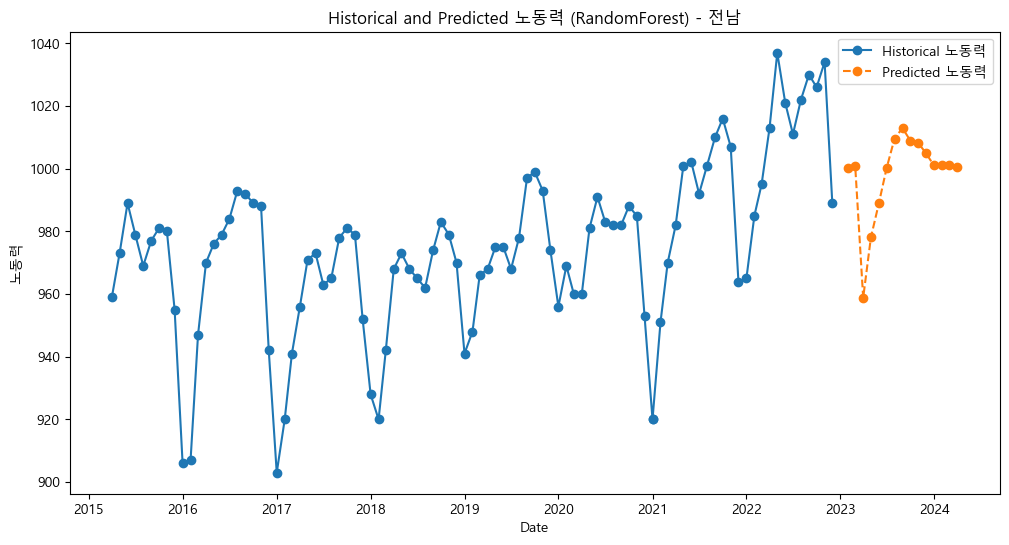


=== 인천 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -12.81    | 9.367     | 19.11     | 233.0     |
| 2         | -7.153    | 13.18     | 4.808     | 89.0      |
| 3         | -13.19    | 3.987     | 17.59     | 200.3     |
| 4         | -6.157    | 15.04     | 2.371     | 292.5     |
| 5         | -7.745    | 17.15     | 5.822     | 95.46     |
| 6         | -13.54    | 3.0       | 20.0      | 50.0      |
| 7         | -6.16     | 15.35     | 2.72      | 293.5     |
| 8         | -13.42    | 3.0       | 20.0      | 295.7     |
| 9         | -13.41    | 3.0       | 20.0      | 98.36     |
| 10        | -6.318    | 20.0      | 2.0       | 75.54     |
| 11        | -6.192    | 20.0      | 2.0       | 270.1     |
| 12        | -6.361    | 20.0      | 2.0       | 146.4     |
| 13        | -13.5     | 3.999     | 20.0      | 150.8     |
| 14        | -6.371    | 20.0      | 2.0       | 127.1   

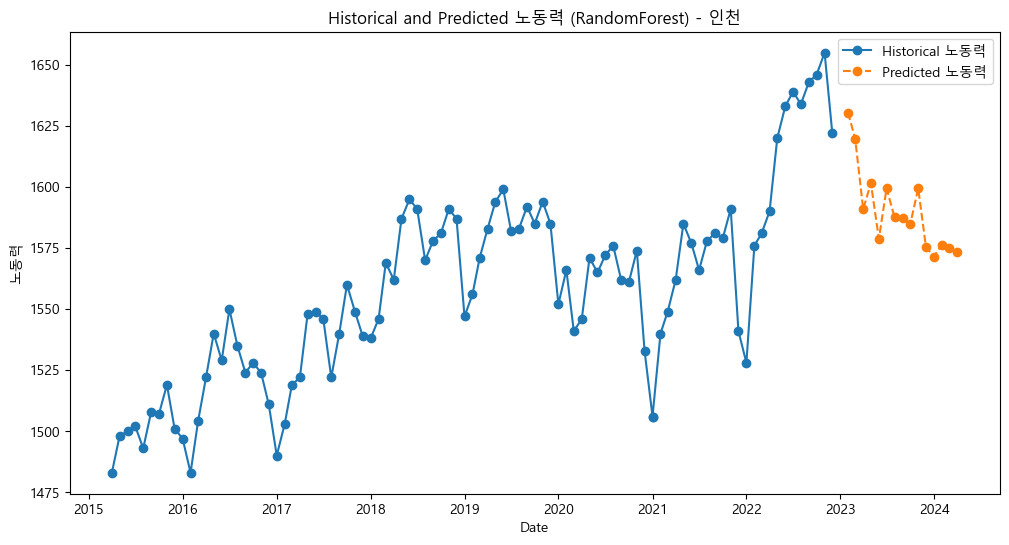


=== 울산 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -4.519    | 9.367     | 19.11     | 233.0     |
| 2         | -2.497    | 13.18     | 4.808     | 89.0      |
| 3         | -4.566    | 3.987     | 17.59     | 200.3     |
| 4         | -2.091    | 15.04     | 2.371     | 292.5     |
| 5         | -2.653    | 17.15     | 5.822     | 95.46     |
| 6         | -4.598    | 20.0      | 20.0      | 50.0      |
| 7         | -2.644    | 13.05     | 5.862     | 88.01     |
| 8         | -4.548    | 3.0       | 16.89     | 300.0     |
| 9         | -2.094    | 20.0      | 2.0       | 281.0     |
| 10        | -3.88     | 3.0       | 2.0       | 103.3     |
| 11        | -2.364    | 6.672     | 2.0       | 279.7     |
| 12        | -4.419    | 20.0      | 17.39     | 276.2     |
| 13        | -3.877    | 3.0       | 2.0       | 263.2     |
| 14        | -2.092    | 13.05     | 2.0       | 285.3   

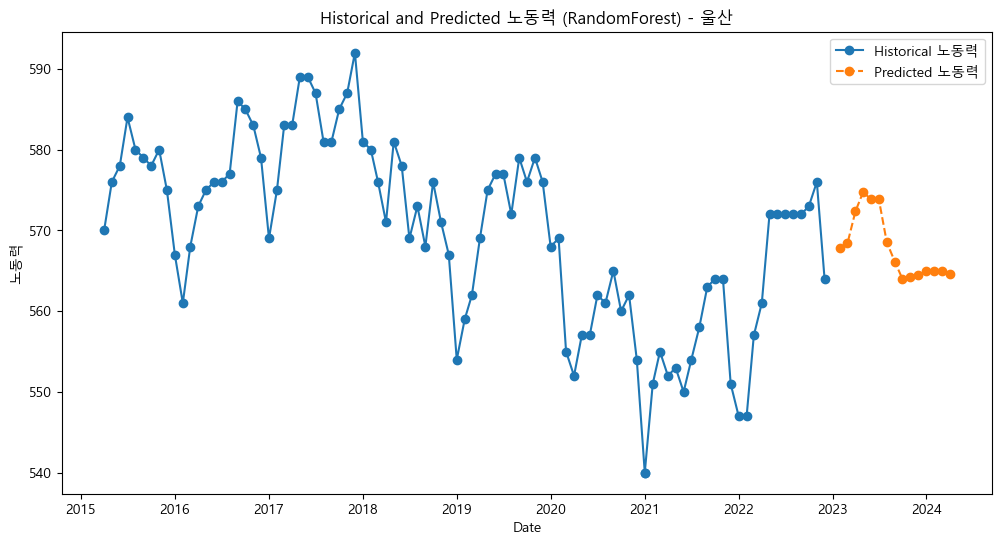


=== 충남 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -21.51    | 9.367     | 19.11     | 233.0     |
| 2         | -12.3     | 13.18     | 4.808     | 89.0      |
| 3         | -22.21    | 3.987     | 17.59     | 200.3     |
| 4         | -10.4     | 15.04     | 2.371     | 292.5     |
| 5         | -13.02    | 17.15     | 5.822     | 95.46     |
| 6         | -22.59    | 20.0      | 20.0      | 50.0      |
| 7         | -11.11    | 15.77     | 3.189     | 292.8     |
| 8         | -18.15    | 3.0       | 2.0       | 281.3     |
| 9         | -11.14    | 6.261     | 2.578     | 298.2     |
| 10        | -22.42    | 3.0       | 17.85     | 93.85     |
| 11        | -11.26    | 20.0      | 2.0       | 78.43     |
| 12        | -15.47    | 4.769     | 2.014     | 69.78     |
| 13        | -20.17    | 19.84     | 15.59     | 77.68     |
| 14        | -22.12    | 3.0       | 18.64     | 300.0   

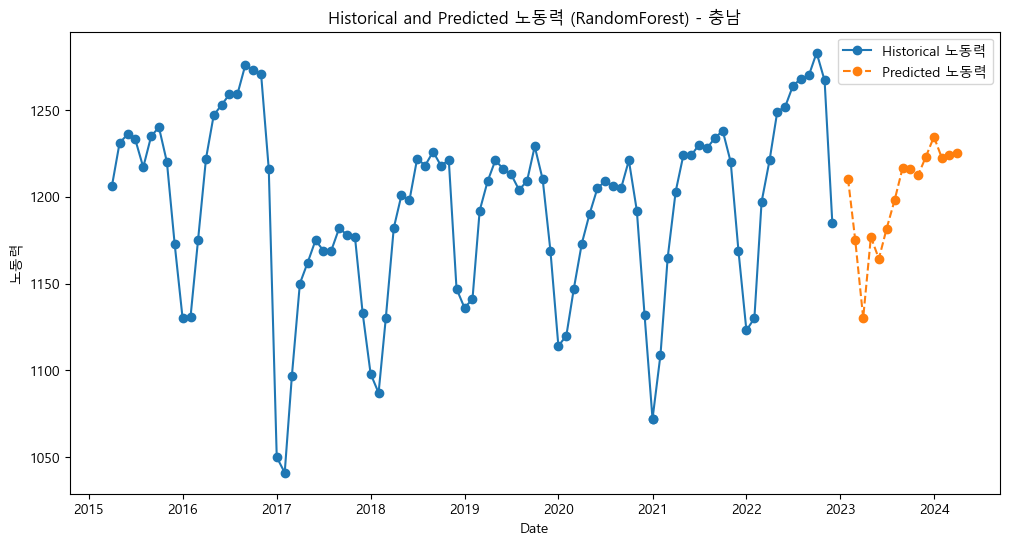


=== 세종 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -5.089    | 9.367     | 19.11     | 233.0     |
| 2         | -1.218    | 13.18     | 4.808     | 89.0      |
| 3         | -4.342    | 3.987     | 17.59     | 200.3     |
| 4         | -0.9853   | 15.04     | 2.371     | 292.5     |
| 5         | -1.265    | 17.15     | 5.822     | 95.46     |
| 6         | -5.894    | 20.0      | 20.0      | 50.0      |
| 7         | -1.29     | 13.05     | 5.862     | 88.01     |
| 8         | -3.717    | 3.0       | 2.0       | 133.3     |
| 9         | -5.136    | 5.215     | 19.84     | 299.0     |
| 10        | -1.004    | 19.61     | 2.113     | 277.7     |
| 11        | -6.106    | 3.0       | 20.0      | 102.5     |
| 12        | -3.569    | 3.0       | 2.0       | 277.2     |
| 13        | -2.43     | 20.0      | 13.77     | 283.2     |
| 14        | -1.295    | 20.0      | 2.0       | 78.73   

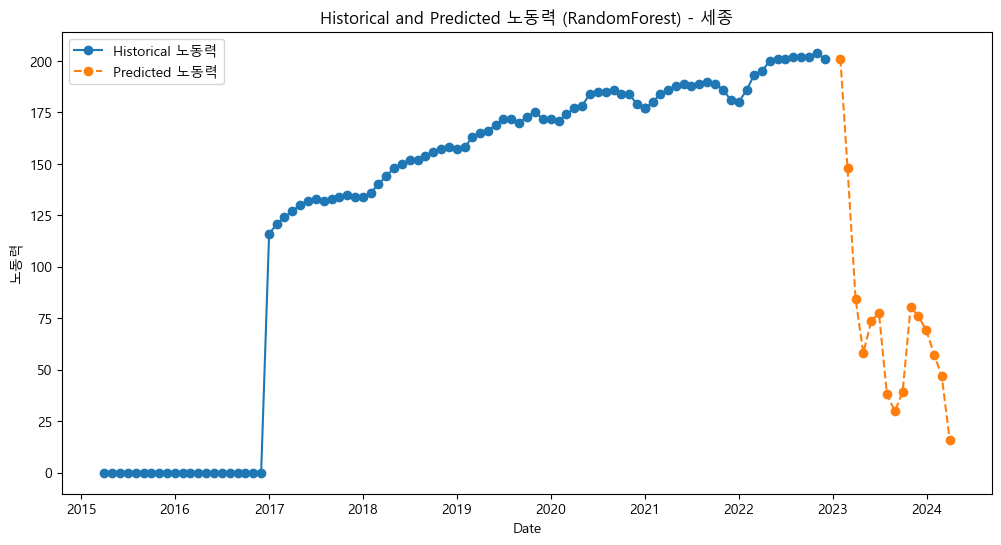


=== 서울 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -29.98    | 9.367     | 19.11     | 233.0     |
| 2         | -17.21    | 13.18     | 4.808     | 89.0      |
| 3         | -30.61    | 3.987     | 17.59     | 200.3     |
| 4         | -14.99    | 15.04     | 2.371     | 292.5     |
| 5         | -18.63    | 17.15     | 5.822     | 95.46     |
| 6         | -31.01    | 3.0       | 20.0      | 50.0      |
| 7         | -15.6     | 15.78     | 3.189     | 292.8     |
| 8         | -25.95    | 3.0       | 2.0       | 275.4     |
| 9         | -22.24    | 4.178     | 5.511     | 299.8     |
| 10        | -30.66    | 3.0       | 17.59     | 93.4      |
| 11        | -14.99    | 20.0      | 2.0       | 282.9     |
| 12        | -15.67    | 19.64     | 2.361     | 74.15     |
| 13        | -15.36    | 20.0      | 2.0       | 139.7     |
| 14        | -30.02    | 20.0      | 19.02     | 146.1   

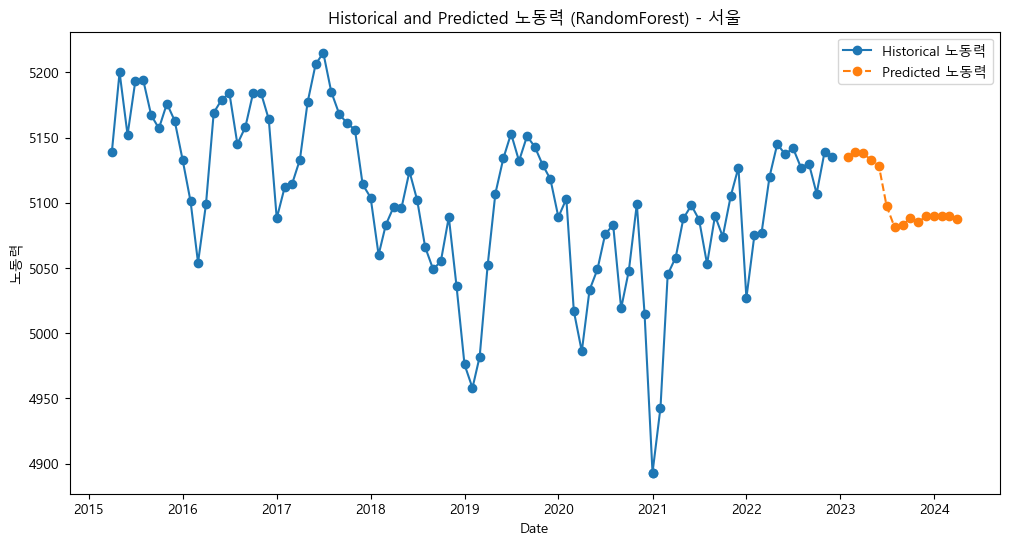


=== 부산 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -11.8     | 9.367     | 19.11     | 233.0     |
| 2         | -6.58     | 13.18     | 4.808     | 89.0      |
| 3         | -11.5     | 3.987     | 17.59     | 200.3     |
| 4         | -5.648    | 15.04     | 2.371     | 292.5     |
| 5         | -7.193    | 17.15     | 5.822     | 95.46     |
| 6         | -12.28    | 3.0       | 20.0      | 50.0      |
| 7         | -5.95     | 15.77     | 3.187     | 292.8     |
| 8         | -9.929    | 3.0       | 2.0       | 278.3     |
| 9         | -6.916    | 5.091     | 2.0       | 300.0     |
| 10        | -11.79    | 3.0       | 18.76     | 92.95     |
| 11        | -5.95     | 19.98     | 3.033     | 77.37     |
| 12        | -6.303    | 6.638     | 2.502     | 74.2      |
| 13        | -5.752    | 20.0      | 2.0       | 132.9     |
| 14        | -5.747    | 20.0      | 2.0       | 149.6   

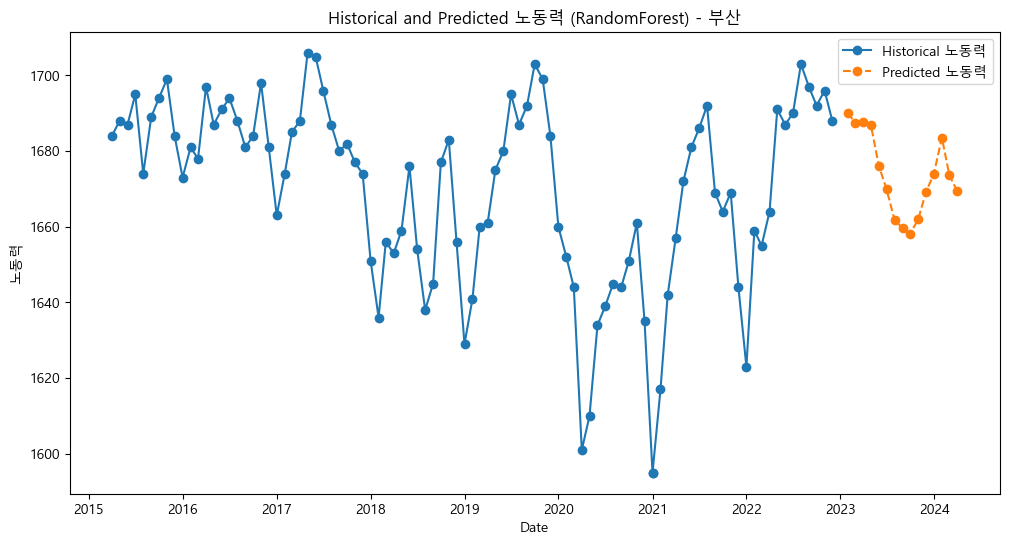


=== 대전 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -5.872    | 9.367     | 19.11     | 233.0     |
| 2         | -2.989    | 13.18     | 4.808     | 89.0      |
| 3         | -5.8      | 3.987     | 17.59     | 200.3     |
| 4         | -2.75     | 15.04     | 2.371     | 292.5     |
| 5         | -3.299    | 17.15     | 5.822     | 95.46     |
| 6         | -6.258    | 3.0       | 20.0      | 50.0      |
| 7         | -3.279    | 13.05     | 5.862     | 88.01     |
| 8         | -5.053    | 3.0       | 2.0       | 97.42     |
| 9         | -3.571    | 20.0      | 6.769     | 300.0     |
| 10        | -4.396    | 11.35     | 10.93     | 287.8     |
| 11        | -2.808    | 8.972     | 2.0       | 299.4     |
| 12        | -2.714    | 19.23     | 2.041     | 84.93     |
| 13        | -6.085    | 20.0      | 20.0      | 146.0     |
| 14        | -2.819    | 20.0      | 2.0       | 68.96   

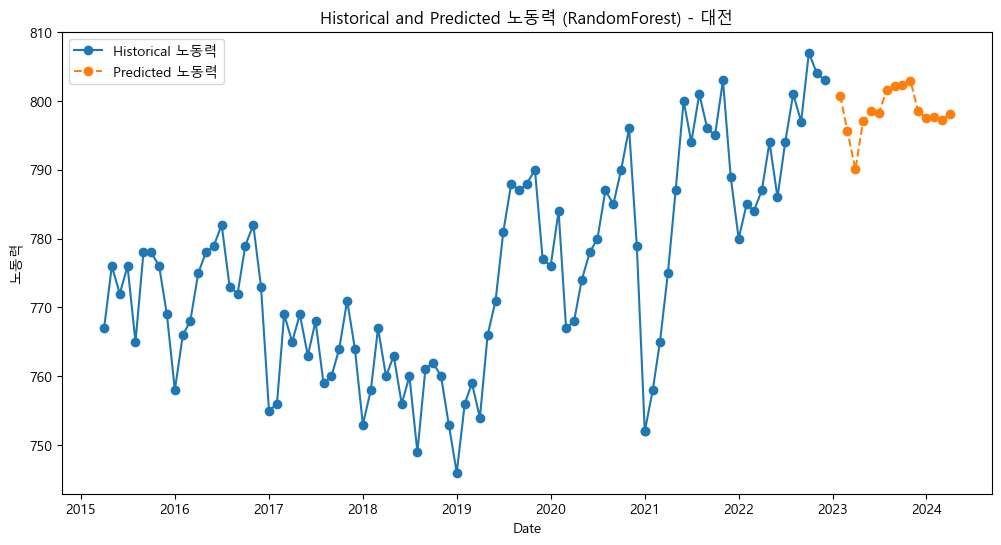


=== 대구 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -13.49    | 9.367     | 19.11     | 233.0     |
| 2         | -6.65     | 13.18     | 4.808     | 89.0      |
| 3         | -13.0     | 3.987     | 17.59     | 200.3     |
| 4         | -6.018    | 15.04     | 2.371     | 292.5     |
| 5         | -7.305    | 17.15     | 5.822     | 95.46     |
| 6         | -13.79    | 3.0       | 20.0      | 50.0      |
| 7         | -6.022    | 15.41     | 2.783     | 293.5     |
| 8         | -13.94    | 3.0       | 20.0      | 300.0     |
| 9         | -13.85    | 3.0       | 20.0      | 97.61     |
| 10        | -5.748    | 20.0      | 2.0       | 76.34     |
| 11        | -6.002    | 20.0      | 2.0       | 270.1     |
| 12        | -5.974    | 20.0      | 2.0       | 146.3     |
| 13        | -13.88    | 4.825     | 20.0      | 151.3     |
| 14        | -5.866    | 20.0      | 2.0       | 127.1   

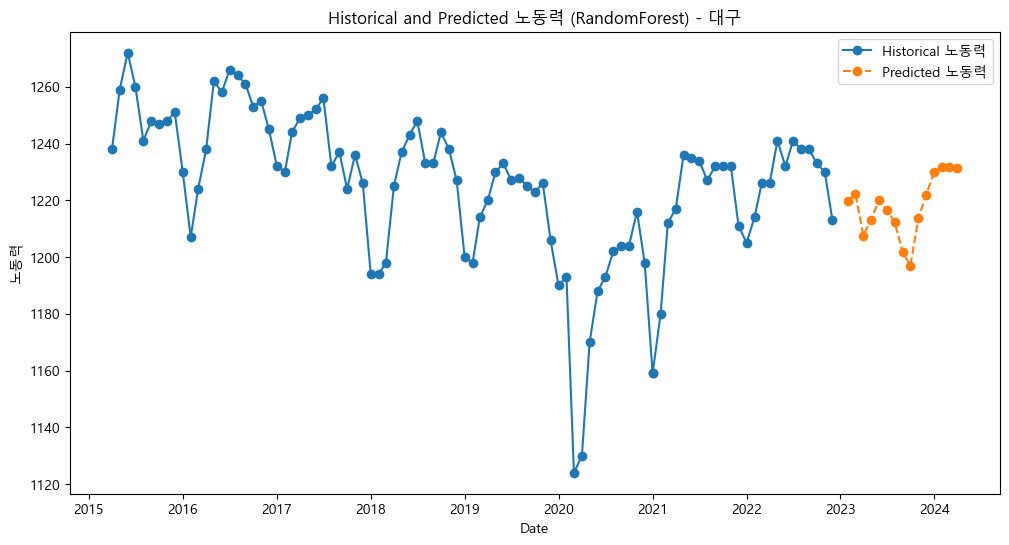


=== 광주 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -5.457    | 9.367     | 19.11     | 233.0     |
| 2         | -3.14     | 13.18     | 4.808     | 89.0      |
| 3         | -5.641    | 3.987     | 17.59     | 200.3     |
| 4         | -2.664    | 15.04     | 2.371     | 292.5     |
| 5         | -3.425    | 17.15     | 5.822     | 95.46     |
| 6         | -5.811    | 3.0       | 20.0      | 50.0      |
| 7         | -3.378    | 13.05     | 5.862     | 88.01     |
| 8         | -4.87     | 12.48     | 13.58     | 300.0     |
| 9         | -2.661    | 18.11     | 2.0       | 283.5     |
| 10        | -5.013    | 3.907     | 2.513     | 283.0     |
| 11        | -4.158    | 20.0      | 8.815     | 287.8     |
| 12        | -3.186    | 6.661     | 2.0       | 95.43     |
| 13        | -2.665    | 20.0      | 2.0       | 273.7     |
| 14        | -2.663    | 20.0      | 2.0       | 262.0   

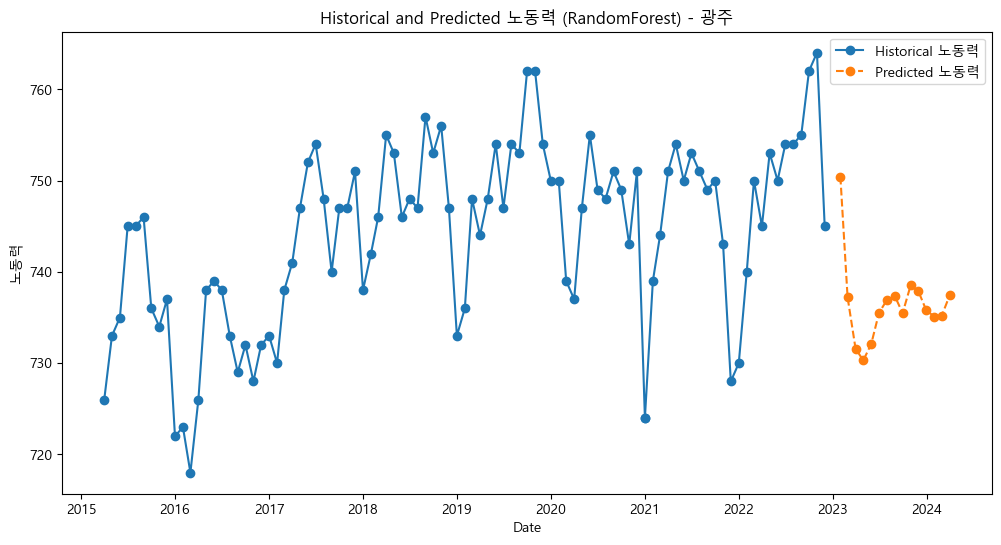


=== 충북 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -13.84    | 9.367     | 19.11     | 233.0     |
| 2         | -7.373    | 13.18     | 4.808     | 89.0      |
| 3         | -13.95    | 3.987     | 17.59     | 200.3     |
| 4         | -6.543    | 15.04     | 2.371     | 292.5     |
| 5         | -8.005    | 17.15     | 5.822     | 95.46     |
| 6         | -14.4     | 20.0      | 20.0      | 50.0      |
| 7         | -6.543    | 16.14     | 2.35      | 292.1     |
| 8         | -14.09    | 20.0      | 20.0      | 300.0     |
| 9         | -6.657    | 8.628     | 2.0       | 275.7     |
| 10        | -14.48    | 3.0       | 20.0      | 123.2     |
| 11        | -6.619    | 20.0      | 2.0       | 262.2     |
| 12        | -6.694    | 20.0      | 2.0       | 162.4     |
| 13        | -14.15    | 20.0      | 20.0      | 163.5     |
| 14        | -13.34    | 20.0      | 17.32     | 269.6   

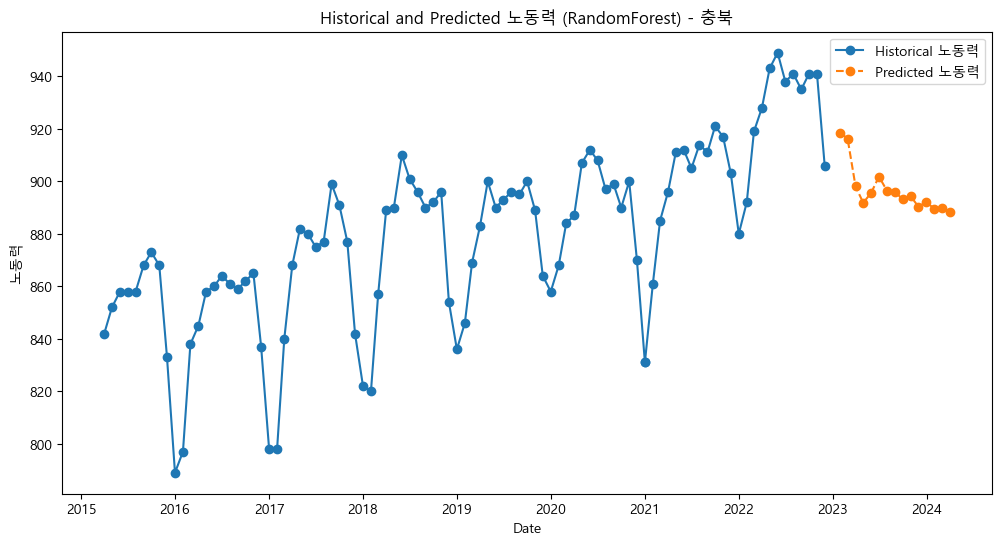


=== 전국 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -261.6    | 9.367     | 19.11     | 233.0     |
| 2         | -123.6    | 13.18     | 4.808     | 89.0      |
| 3         | -244.2    | 3.987     | 17.59     | 200.3     |
| 4         | -104.0    | 15.04     | 2.371     | 292.5     |
| 5         | -131.0    | 17.15     | 5.822     | 95.46     |
| 6         | -273.3    | 20.0      | 20.0      | 50.0      |
| 7         | -109.2    | 15.8      | 3.215     | 292.8     |
| 8         | -202.8    | 3.0       | 2.0       | 274.1     |
| 9         | -204.1    | 3.717     | 6.768     | 299.9     |
| 10        | -244.9    | 3.0       | 17.22     | 95.59     |
| 11        | -104.4    | 20.0      | 2.0       | 282.8     |
| 12        | -108.1    | 19.64     | 2.361     | 74.15     |
| 13        | -158.3    | 4.323     | 2.218     | 71.49     |
| 14        | -105.7    | 20.0      | 2.0       | 132.8   

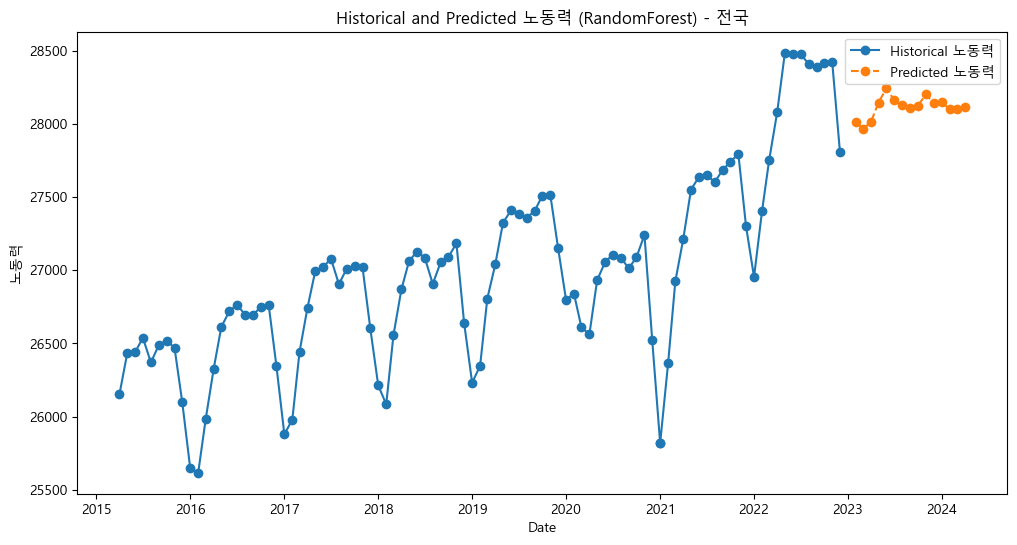


=== 경북 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -17.22    | 9.367     | 19.11     | 233.0     |
| 2         | -9.105    | 13.18     | 4.808     | 89.0      |
| 3         | -17.54    | 3.987     | 17.59     | 200.3     |
| 4         | -8.021    | 15.04     | 2.371     | 292.5     |
| 5         | -9.826    | 17.15     | 5.822     | 95.46     |
| 6         | -17.95    | 20.0      | 20.0      | 50.0      |
| 7         | -8.269    | 15.8      | 3.21      | 292.8     |
| 8         | -14.38    | 3.0       | 2.0       | 272.9     |
| 9         | -14.57    | 3.717     | 6.768     | 299.9     |
| 10        | -17.69    | 3.0       | 17.63     | 93.8      |
| 11        | -8.036    | 20.0      | 2.0       | 283.2     |
| 12        | -8.109    | 20.0      | 2.0       | 77.53     |
| 13        | -8.161    | 20.0      | 2.0       | 136.3     |
| 14        | -16.92    | 20.0      | 18.61     | 146.3   

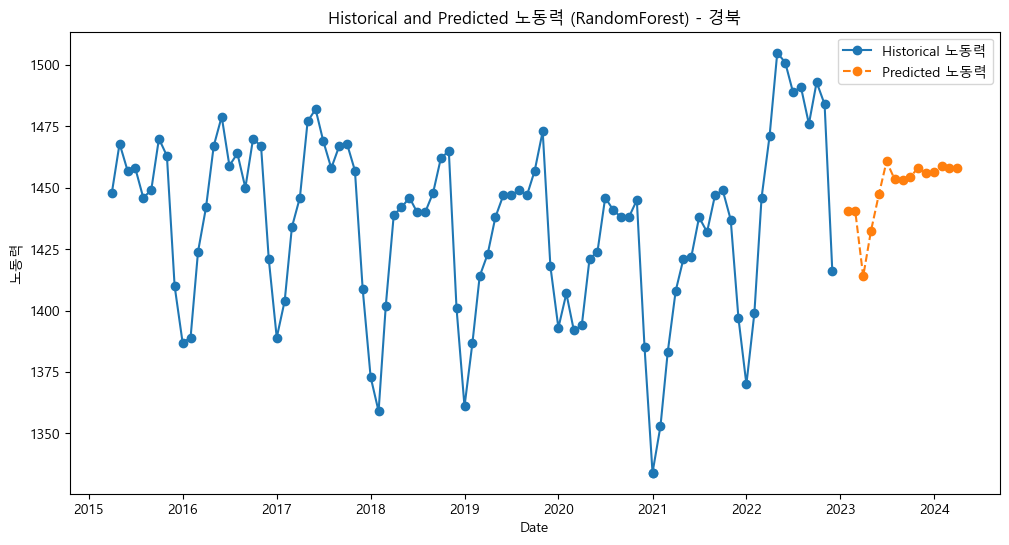


=== 전북 ===
|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -12.07    | 9.367     | 19.11     | 233.0     |
| 2         | -5.584    | 13.18     | 4.808     | 89.0      |
| 3         | -11.69    | 3.987     | 17.59     | 200.3     |
| 4         | -5.172    | 15.04     | 2.371     | 292.5     |
| 5         | -6.038    | 17.15     | 5.822     | 95.46     |
| 6         | -12.79    | 20.0      | 20.0      | 50.0      |
| 7         | -5.164    | 15.01     | 2.868     | 291.3     |
| 8         | -12.84    | 3.0       | 20.0      | 300.0     |
| 9         | -12.77    | 3.0       | 20.0      | 98.52     |
| 10        | -5.114    | 20.0      | 2.0       | 77.56     |
| 11        | -5.206    | 20.0      | 2.0       | 269.5     |
| 12        | -5.148    | 20.0      | 2.0       | 145.7     |
| 13        | -12.55    | 20.0      | 20.0      | 158.0     |
| 14        | -5.095    | 20.0      | 2.0       | 127.3   

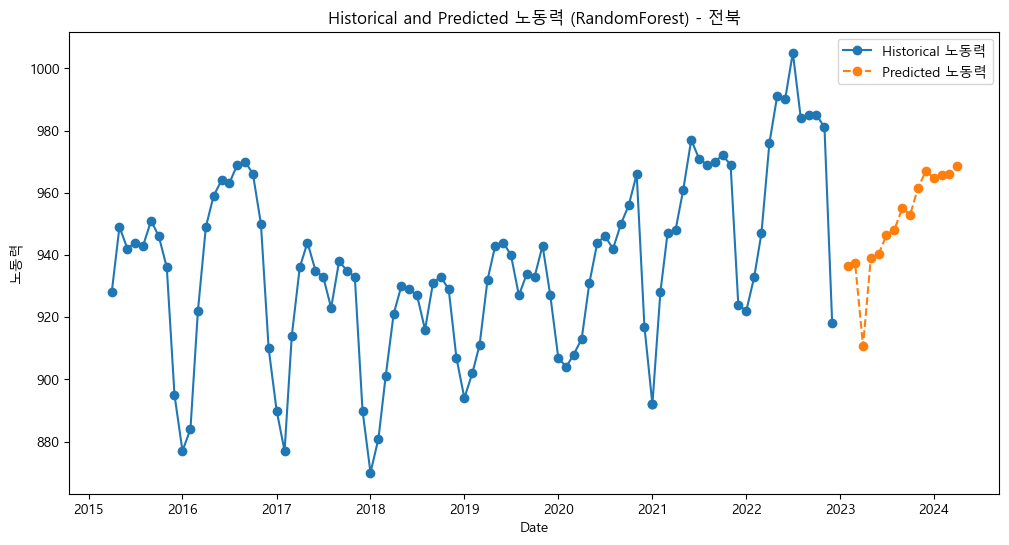

,Date,Predicted,City
0,2023-01-31,793.426357,강원
1,2023-02-28,791.418605,강원
2,2023-03-31,766.775194,강원
3,2023-04-30,778.046512,강원
4,2023-05-31,782.426357,강원


In [ ]:
def create_lag_features(df, target_col, lags):
    for lag in range(1, lags+1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

def train_and_predict(city_name, df, best_params):
    df = df.copy()
    df.drop(columns='시도별', inplace=True)
    
    df = create_lag_features(df, '노동력', 3)
    
    df = df.dropna()
    
    X = df.drop(columns=['노동력', '날짜'])
    y = df['노동력']

    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(X, y)
    
    last_data = df.iloc[-1].copy()
    future_dates = pd.date_range(start=df['날짜'].max() + pd.DateOffset(months=1), periods=24, freq='M')
    
    future_predictions = []
    for _ in range(24):
        new_data = {col: last_data[col] if col in last_data else 0 for col in X.columns}
        future_X = pd.DataFrame([new_data], columns=X.columns)
        
        future_X = future_X.apply(pd.to_numeric, errors='coerce')
        
        if future_X.isnull().values.any() or np.isinf(future_X.values).any():
            future_X = future_X.fillna(0)  
            future_X = future_X.replace([np.inf, -np.inf], 0) 
        
        pred = model.predict(future_X)
        future_predictions.append(pred[0])
        
        last_data = last_data.shift(1)
        last_data.update({col: pred[0] for col in X.columns if '노동력_lag' in col})
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['날짜'], df['노동력'], label='Historical 노동력', marker='o')
    plt.plot(future_dates[:15], future_predictions[:15], label='Predicted 노동력', marker='o', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('노동력')
    plt.title(f'Historical and Predicted 노동력 (RandomForest) - {city_name}')
    plt.legend()
    plt.show()

    results_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted': future_predictions,
        'City': city_name
    })
    
    return results_df

all_future_results = pd.DataFrame() 
for i, city_name in enumerate(city_list):
    print(f'\n=== {city_name} ===')
    best_params = bayesian_opt_rf(city_df_list[i]) 
    
    city_future_results = train_and_predict(city_name, city_df_list[i], best_params)  # 각 시도별 학습 및 예측
    all_future_results = pd.concat([all_future_results, city_future_results], ignore_index=True) 

all_future_results.head()

In [213]:
all_future_results['Date'] = pd.to_datetime(all_future_results['Date'])
all_future_results['Date'] = all_future_results['Date'].apply(lambda x: x.replace(day=1))
all_future_results = all_future_results[all_future_results['Date']<'2024-04-01']
# all_future_results.to_csv(path+'RF_Prediction_2023_2024.csv', encoding="utf-8-sig", index=False)

### 5. 모델 해석 (LIME)

In [14]:
def lime_result(df, n_estimators, max_depth, min_samples_split):
    df = df.copy()
    df.drop(columns='시도별', inplace=True)

    df = create_lag_features(df, '노동력', 3)
    df = df.dropna()

    X = df.drop(columns=['노동력', '날짜'])
    y = df['노동력']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    model.fit(X_train, y_train)

    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                       feature_names=X_train.columns, 
                                                       class_names=['노동력'], 
                                                       mode='regression')

    # 테스트 19개에 대해 LIME 해석 수행
    for i in range(len(X_test)):
        print(f"\n테스트 샘플 {i+1}:")
    
        exp = explainer.explain_instance(X_test.iloc[i].values, model.predict)
        exp.show_in_notebook(show_table=True)
    
        print(exp.as_list())


In [ ]:
# 울산 
print("---울산---")
lime_result(city_df_list[6], n_estimators=298, max_depth=19, min_samples_split=2)[:5]

# LIME 결과 생략